In [7]:
include("../Algebra/Gradients.jl")
include("../Algebra/Hamiltonians.jl")
include("../Algebra/Matrices.jl")
include("../Algebra/Propagators.jl")
include("../Amplitudes/Chebyshev.jl")
include("../Costs/Costs.jl")
include("../Gates/Xgate.jl")
using LinearAlgebra, Optim
using BenchmarkTools, Distributions

In [8]:
ω_c = 5
ω_q = 2
χ = 3e-3
N = 6
amp_c = 1
amp_q = 1

1

In [10]:
I_qubit = Matrix(I,2,2)
I_cavity = Matrix(I,N,N)
#X_gate = kron(x_gate(N, Array[[3,4], [5,6], [7,8]]), I_qubit)
X_gate = kron(x_gate(N, Array[[3,4]]), I_qubit)

θ = π/2.5
RZ = kron(Rz(N, Array[[3,4]], θ/2), I_qubit)
RX = kron(Rx(N, Array[[3,4]], θ/2), I_qubit)

sx = kron(I_cavity, [0 1; 1 0])
sy = kron(I_cavity, [0 -1im; 1im 0])
# generating matrices
a,adag,sp,sm,sz = generate_matrices(N)

ψ_initial = zeros(N)
ψ_initial[1] = 1
ψ_initial = kron(ψ_initial/norm(ψ_initial), [0,1])

# ψ_initial = [0.0
# 0.042364880640716744
# 0.0
# 0.28885144075298463
# 0.0
# 0.16339860379664017
# 0.0
# 0.4589052841372305
# 0.0
# 0.5284511784719409
# 0.0
# 0.22306739569809422
# 0.0
# 0.3219611737913927
# 0.0
# 0.4947708459988468]
# ψ_final_u = Udue * ψ_initial
# ψ_final_x = RX * ψ_initial
# ψ_final_x_gate = X_gate * ψ_initial

12-element Vector{Float64}:
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [11]:
disp(b) = exp(b * adag - b * a)
snap(x) = kron(Diagonal(exp.(-1im.*x)),I_qubit)

ECD(β) = exp(β/2 * adag - β'/2 * a) * sp + exp(-β/2 * adag + β'/2 * a) * sm
ROT(ϕ, θ) = exp(-1im * θ / 2 * ( sx * cos(ϕ) + sy * sin(ϕ) )) 

ROT (generic function with 1 method)

In [12]:
function snap_disp_classic(coefficients, unitary, N, blocks,disp,snap)

    αsi = coefficients[1: blocks]
    θs = coefficients[blocks + 1 : end]
    propagator = Matrix{ComplexF64}(I,N,N)
    q_d = Int(N/2)

    for i in 1:blocks
        propagator = propagator * disp(αsi[i]) * snap(θs[(i - 1) * q_d + 1 : i * q_d])
    end

    return 1 - norm(tr(propagator*unitary') / N)^2
    
end

function snap_disp_classic_gate(coefficients, unitary, N, blocks,disp,snap)

    αsi = coefficients[1: blocks]
    θs = coefficients[blocks + 1 : end]
    propagator = Matrix{ComplexF64}(I,N,N)
    q_d = Int(N/2)

    for i in 1:blocks
        propagator = propagator * disp(αsi[i]) * snap(θs[(i - 1) * q_d + 1 : i * q_d])
    end

    return propagator
    
end

function snap_disp_cost_gate(coefficients, unitary, N, blocks,disp,snap)

    L = length(coefficients)
    αs = coefficients[1: blocks]
    q_d = Int(N/2)

    θs = coefficients[blocks + 1 : end]

    propagator = Matrix{ComplexF64}(I,N,N)

    for i in 1:blocks
        propagator = propagator * disp(αs[i]) * snap(θs[(i - 1) * q_d + 1 : i * q_d]) * disp(αs[i])'
    end

    return 1 - norm(tr(propagator*unitary) / N)^2
    
end

function snap_disp_cost_gate_norm(coefficients, unitary, N, blocks,disp,snap)

    L = length(coefficients)
    αs = coefficients[1: blocks]
    q_d = Int(N/2)

    θs = coefficients[blocks + 1 : end]

    propagator = Matrix{ComplexF64}(I,N,N)

    for i in 1:blocks
        propagator = propagator * disp(αs[i]) * snap(θs[(i - 1) * q_d + 1 : i * q_d]) * disp(αs[i])'
    end

    return norm(propagator - unitary)
    
end

function snap_disp_cost_gate_opnorm(coefficients, unitary, N, blocks,disp,snap)

    L = length(coefficients)
    αs = coefficients[1: blocks]
    q_d = Int(N/2)

    θs = coefficients[blocks + 1 : end]

    propagator = Matrix{ComplexF64}(I,N,N)

    for i in 1:blocks
        propagator = propagator * disp(αs[i]) * snap(θs[(i - 1) * q_d + 1 : i * q_d]) * disp(αs[i])'
    end

    return opnorm(propagator - unitary)
    
end

function snap_disp_cost_state_prep(coefficients, N, ψ_n, ψ_m, blocks)

    αs = coefficients[1: blocks]

    θs = coefficients[blocks + 1 : end]

    propagator = Matrix{ComplexF64}(I,N,N)

    for i in 1:blocks
        propagator = propagator * disp(αs[i]) * snap(θs[(i - 1) * N + 1 : i * N]) * disp(αs[i])'
    end

    return 1 - norm(ψ_m' * propagator * ψ_n)^2
    
end


snap_disp_cost_state_prep (generic function with 1 method)

## trace

In [13]:
costs = []
for blocks in 5:1:5
    it_costs = []
    for iteration in 1:20
        println("blocks: ", blocks," iterations :", iteration)
        coefficients_initial = zeros((N + 1 ) * blocks)
        coefficients_initial[1: blocks] = rand(blocks)*2 .-1
        coefficients_initial[blocks + 1:end] = rand(N*blocks) * 2 * pi .- pi
        f(x) = snap_disp_cost_gate(x, X_gate, N * 2, blocks,disp,snap)
        #g(x) = snap_disp_cost_state_prep(x, N * 2, ψ_initial, ψ_final_x_gate, blocks)
        res = Optim.optimize(f, coefficients_initial , LBFGS(), Optim.Options(show_trace=true, show_every=100))
        push!(it_costs,Optim.minimum(res))
        println(Optim.minimum(res))
    end
    println(it_costs)
    println(minimum(it_costs))
    push!(costs,minimum(it_costs))
end

blocks: 5 iterations :1
Iter     Function value   Gradient norm 


     0     8.270362e-01     6.479010e-01
 * time: 0.027083873748779297


   100     4.960391e-03     1.780768e-02
 * time: 2.347498893737793


   200     2.145813e-03     7.195344e-03
 * time: 4.185906887054443


   300     8.745262e-04     3.146719e-03
 * time: 5.981400012969971


   400     1.717470e-04     3.066757e-03
 * time: 7.755313873291016


   500     3.046169e-05     1.119057e-04
 * time: 9.50270700454712


   600     2.837245e-05     2.214904e-04
 * time: 11.367291927337646


   700     2.653910e-05     8.056582e-05
 * time: 13.200841903686523


   800     2.629334e-05     4.185353e-05
 * time: 14.996579885482788


   900     2.582368e-05     9.461382e-05
 * time: 16.772507905960083


  1000     2.554826e-05     3.687514e-05
 * time: 18.521437883377075


2.554826288914125e-5
blocks: 5 iterations :2
Iter     Function value   Gradient norm 
     0     9.792796e-01     2.020269e-01
 * time: 5.91278076171875e-5


   100     2.261933e-02     1.844229e-02
 * time: 1.8157999515533447


   200     6.501526e-03     4.668021e-03
 * time: 3.7069480419158936


   300     3.343265e-03     1.649250e-03
 * time: 5.553476095199585


   400     3.309972e-03     6.605792e-05
 * time: 7.4423980712890625


   500     3.309727e-03     7.387196e-06
 * time: 9.422116994857788


   600     3.309726e-03     1.658151e-07
 * time: 11.348669052124023


0.00330972604307167
blocks: 5 iterations :3
Iter     Function value   Gradient norm 
     0     9.838654e-01     1.106638e-01
 * time: 4.792213439941406e-5


   100     2.771429e-03     5.575704e-03
 * time: 1.8379700183868408


   200     2.001191e-03     2.920460e-03
 * time: 4.010684967041016


   300     6.292320e-04     1.690559e-03
 * time: 6.166179895401001


   400     1.712670e-04     1.326074e-03
 * time: 9.168479919433594


   500     7.721997e-05     4.680392e-04
 * time: 11.39275312423706


   600     1.783038e-05     1.165220e-03
 * time: 13.964634895324707


   700     4.868083e-06     4.728907e-05
 * time: 15.978248119354248


   800     4.656364e-06     1.007561e-04
 * time: 19.797842979431152


   900     4.567681e-06     1.645063e-05
 * time: 22.067656993865967


  1000     4.505113e-06     4.658928e-05
 * time: 24.76901412010193


4.505113181285658e-6
blocks: 5 iterations :4
Iter     Function value   Gradient norm 
     0     9.744862e-01     1.053639e-01
 * time: 9.393692016601562e-5


   100     2.564474e-02     2.832645e-02
 * time: 1.9999709129333496


   200     4.787850e-03     5.520063e-03
 * time: 4.999933958053589


   300     4.144906e-03     7.987994e-07
 * time: 7.951380968093872


0.0041449056692258734
blocks: 5 iterations :5
Iter     Function value   Gradient norm 
     0     9.738453e-01     2.568490e-01
 * time: 0.0003349781036376953


   100     2.197750e-02     5.471864e-03
 * time: 2.17317795753479


   200     1.986222e-02     5.442103e-03
 * time: 4.509030103683472


   300     1.878163e-02     9.849829e-03
 * time: 6.717884063720703


   400     1.760080e-02     7.463496e-04
 * time: 8.6873619556427


   500     1.693906e-02     5.329102e-03
 * time: 10.976371049880981


   600     1.624010e-02     2.373107e-03
 * time: 12.817399978637695


   700     1.299493e-02     2.873386e-02
 * time: 14.68109917640686


   800     5.402655e-03     2.296748e-03
 * time: 16.545080184936523


   900     5.329780e-03     4.256843e-04
 * time: 18.586881160736084


  1000     5.329378e-03     2.862435e-05
 * time: 20.766725063323975


0.005329377795836532
blocks: 5 iterations :6
Iter     Function value   Gradient norm 
     0     9.578890e-01     1.313692e-01
 * time: 0.00010919570922851562


   100     1.322387e-02     5.578882e-02
 * time: 2.63789701461792


   200     6.115265e-03     7.374644e-04
 * time: 5.698233127593994


   300     6.106420e-03     4.539747e-07
 * time: 8.366942167282104


0.0061064196552250705
blocks: 5 iterations :7
Iter     Function value   Gradient norm 
     0     9.823126e-01     8.340946e-02
 * time: 0.00012087821960449219


   100     1.519808e-02     3.765784e-02
 * time: 2.4078938961029053


   200     9.413634e-04     8.158071e-04
 * time: 4.8673930168151855


   300     8.896254e-04     2.581464e-04
 * time: 7.378772974014282


   400     5.892433e-04     1.984708e-03
 * time: 9.609363794326782


   500     3.522418e-04     4.370742e-03
 * time: 13.225889921188354


   600     2.807519e-04     8.915256e-04
 * time: 15.344604969024658


   700     2.471436e-04     3.692374e-04
 * time: 17.454104900360107


   800     2.412704e-04     7.531015e-04
 * time: 19.462705850601196


   900     2.232661e-04     7.519574e-04
 * time: 21.479291915893555


  1000     2.093761e-04     1.079874e-03
 * time: 23.39778184890747


0.00020937614370120095
blocks: 5 iterations :8
Iter     Function value   Gradient norm 
     0     9.764546e-01     1.802234e-01
 * time: 5.0067901611328125e-5


   100     8.047087e-03     1.358765e-02
 * time: 1.9589390754699707


   200     4.872500e-04     6.924853e-03
 * time: 3.9261770248413086


   300     7.881993e-05     2.606662e-03
 * time: 5.872244119644165


   400     6.601206e-05     9.996990e-05
 * time: 7.730828046798706


   500     6.560899e-05     4.110409e-05
 * time: 9.676330089569092


   600     6.509164e-05     4.013914e-05
 * time: 11.614645004272461


   700     6.501432e-05     1.794440e-05
 * time: 13.693896055221558


   800     6.490053e-05     8.837960e-05
 * time: 15.634209156036377


   900     6.472371e-05     3.861108e-05
 * time: 17.49713110923767


  1000     6.434860e-05     2.981130e-05
 * time: 19.383445978164673


6.434859972370699e-5
blocks: 5 iterations :9
Iter     Function value   Gradient norm 
     0     9.728383e-01     2.114272e-01
 * time: 5.1021575927734375e-5


   100     5.587443e-03     8.111076e-03
 * time: 2.1311869621276855


   200     3.497405e-03     7.102645e-03
 * time: 4.723870038986206


   300     2.585966e-03     1.562169e-04
 * time: 6.897517919540405


   400     2.585861e-03     2.166605e-07
 * time: 8.976269960403442


0.002585861195892103
blocks: 5 iterations :10
Iter     Function value   Gradient norm 
     0     9.570463e-01     4.742681e-01
 * time: 4.601478576660156e-5


   100     6.645634e-03     3.455862e-03
 * time: 2.093319892883301


   200     6.452007e-03     3.008965e-05
 * time: 4.262250900268555


   300     6.451999e-03     1.149558e-08
 * time: 6.311147928237915


0.006451999162043975
blocks: 5 iterations :11
Iter     Function value   Gradient norm 
     0     9.695091e-01     2.002717e-01
 * time: 4.792213439941406e-5


   100     5.102497e-03     1.551288e-03
 * time: 2.0718250274658203


   200     4.612942e-03     6.641063e-04
 * time: 4.164979934692383


   300     4.609316e-03     1.164514e-05
 * time: 6.501355886459351


   400     4.609309e-03     1.302970e-06
 * time: 8.704246997833252


   500     4.609309e-03     2.894669e-06
 * time: 10.841096878051758


   600     4.609309e-03     4.530763e-07
 * time: 12.961534976959229


0.004609309265862338
blocks: 5 iterations :12
Iter     Function value   Gradient norm 
     0     9.155249e-01     4.676955e-01
 * time: 6.008148193359375e-5


   100     2.482285e-02     9.333952e-02
 * time: 2.04242205619812


   200     1.392706e-03     1.054348e-02
 * time: 4.013297080993652


   300     2.703895e-04     2.484071e-03
 * time: 5.929945945739746


   400     1.330799e-04     1.908337e-03
 * time: 7.800809860229492


   500     1.062082e-04     4.381578e-04
 * time: 9.787843942642212


   600     7.699160e-05     1.931630e-04
 * time: 11.734029054641724


   700     5.587385e-05     1.911779e-04
 * time: 13.726126909255981


   800     4.600409e-05     2.062320e-04
 * time: 15.682034969329834


   900     4.369015e-05     2.423554e-04
 * time: 17.776834964752197


  1000     3.728645e-05     1.182941e-04
 * time: 19.860190868377686


3.728645357803373e-5
blocks: 5 iterations :13
Iter     Function value   Gradient norm 
     0     6.626630e-01     3.027531e-01
 * time: 4.696846008300781e-5


   100     1.549371e-02     2.053606e-02
 * time: 2.0580289363861084


   200     2.499097e-03     8.746215e-03
 * time: 4.159090042114258


   300     1.883566e-03     4.963286e-03
 * time: 6.2701239585876465


   400     1.455348e-03     5.103579e-03
 * time: 8.35991096496582


   500     4.296700e-04     1.981892e-03
 * time: 10.326026916503906


   600     6.316097e-05     1.798917e-03
 * time: 12.336477994918823


   700     2.355706e-05     5.084283e-04
 * time: 14.44729208946228


   800     1.340556e-05     9.402250e-05
 * time: 16.577023029327393


   900     1.091620e-05     3.341563e-04
 * time: 18.70349407196045


  1000     9.088486e-06     1.079168e-04
 * time: 20.797222137451172


9.08848578717869e-6
blocks: 5 iterations :14
Iter     Function value   Gradient norm 
     0     9.630048e-01     3.099899e-01
 * time: 4.887580871582031e-5


   100     6.060158e-03     1.823550e-02
 * time: 2.049440860748291


   200     3.169214e-03     2.311471e-03
 * time: 4.320113897323608


   300     3.010634e-03     1.283027e-03
 * time: 7.021003007888794


   400     2.598431e-03     2.234529e-03
 * time: 9.615419864654541


   500     1.005943e-03     3.223182e-03
 * time: 11.983749866485596


   600     2.430207e-04     3.409785e-03
 * time: 14.340081930160522


   700     1.667995e-04     2.729997e-04
 * time: 17.035640001296997


   800     1.495598e-04     1.916588e-04
 * time: 19.413967847824097


   900     1.321450e-04     4.977515e-04
 * time: 21.692079782485962


  1000     8.971068e-05     4.502708e-04
 * time: 24.2014319896698


8.971068308738506e-5
blocks: 5 iterations :15
Iter     Function value   Gradient norm 
     0     8.882858e-01     2.266873e-01
 * time: 0.0016181468963623047


   100     3.433889e-02     6.312567e-03
 * time: 2.490326166152954


   200     1.649878e-02     3.946851e-03
 * time: 5.344029188156128


   300     1.643909e-02     4.094848e-06
 * time: 7.820021152496338


0.016439090252213906
blocks: 5 iterations :16
Iter     Function value   Gradient norm 
     0     9.693313e-01     1.668091e-01
 * time: 9.489059448242188e-5


   100     5.536278e-04     4.856300e-03
 * time: 2.562574863433838


   200     1.608517e-04     7.016703e-04
 * time: 4.88312292098999


   300     7.623755e-05     2.885817e-04
 * time: 7.7002599239349365


   400     3.994267e-05     6.654571e-04
 * time: 10.356863021850586


   500     3.685349e-05     8.413635e-05
 * time: 12.656301975250244


   600     3.562949e-05     6.730181e-05
 * time: 15.924690008163452


   700     3.382441e-05     9.163743e-05
 * time: 18.5381338596344


   800     3.081227e-05     3.197316e-04
 * time: 21.312165021896362


   900     2.499566e-05     5.357166e-04
 * time: 23.7436580657959


  1000     1.663047e-05     2.348092e-04
 * time: 26.42586398124695


1.66304662060357e-5
blocks: 5 iterations :17
Iter     Function value   Gradient norm 
     0     9.381682e-01     5.002333e-01
 * time: 9.584426879882812e-5


   100     2.273732e-03     3.385831e-03
 * time: 2.743644952774048


   200     1.505547e-03     3.097772e-03
 * time: 5.120405912399292


   300     1.432481e-03     2.286744e-04
 * time: 8.074541807174683


   400     1.431073e-03     9.799706e-05
 * time: 10.622673988342285


   500     1.430998e-03     2.096125e-06
 * time: 14.116518020629883


   600     1.430998e-03     1.618164e-06
 * time: 17.55610203742981


   700     1.430998e-03     3.750457e-07
 * time: 20.17272686958313


   800     1.430998e-03     3.807293e-07
 * time: 23.774768829345703


   900     1.430998e-03     3.169078e-08
 * time: 26.17386484146118


0.001430997710579307
blocks: 5 iterations :18
Iter     Function value   Gradient norm 
     0     9.104932e-01     1.871330e-01
 * time: 0.00011515617370605469


   100     6.990725e-03     2.713756e-02
 * time: 2.399416208267212


   200     2.952878e-03     1.888466e-03
 * time: 4.64049220085144


   300     1.951367e-03     4.917746e-03
 * time: 8.968315124511719


   400     1.769540e-03     3.578711e-03
 * time: 11.206884145736694


   500     1.908075e-04     1.645472e-03
 * time: 13.382291078567505


   600     1.212570e-04     1.106224e-03
 * time: 15.552250146865845


   700     9.197424e-05     1.856548e-04
 * time: 17.6673641204834


   800     9.001647e-05     5.389710e-05
 * time: 19.827583074569702


   900     8.828992e-05     6.274656e-05
 * time: 21.930509090423584


  1000     8.795419e-05     2.015565e-05
 * time: 24.226800203323364


8.795419113671876e-5
blocks: 5 iterations :19
Iter     Function value   Gradient norm 
     0     9.867059e-01     2.367196e-01
 * time: 6.198883056640625e-5


   100     1.091076e-03     1.368521e-02
 * time: 2.0480000972747803


   200     4.666544e-04     2.330525e-03
 * time: 4.206290006637573


   300     1.264606e-04     4.769057e-04
 * time: 6.223242998123169


   400     1.232241e-04     3.008524e-06
 * time: 8.457266092300415


   500     1.232241e-04     2.019153e-07
 * time: 10.651321172714233


0.00012322409494791575
blocks: 5 iterations :20
Iter     Function value   Gradient norm 
     0     8.948408e-01     4.756485e-01
 * time: 5.602836608886719e-5


   100     6.586675e-02     1.123868e-02
 * time: 2.057792901992798


   200     3.466414e-02     4.694238e-02
 * time: 4.099686861038208


   300     2.330376e-02     8.781852e-03
 * time: 6.23456597328186


   400     2.084017e-02     5.720489e-03
 * time: 8.417699813842773


   500     4.012971e-03     4.764230e-03
 * time: 10.493261814117432


   600     1.654632e-03     2.790991e-03
 * time: 12.558501958847046


   700     1.198511e-03     1.149982e-03
 * time: 14.625311851501465


   800     1.189836e-03     1.377453e-06
 * time: 16.767154932022095


   900     1.189836e-03     1.574088e-07
 * time: 18.998955965042114


0.001189835885781254


Any[2.554826288914125e-5, 0.00330972604307167, 4.505113181285658e-6, 0.0041449056692258734, 0.005329377795836532, 0.0061064196552250705, 0.00020937614370120095, 6.434859972370699e-5, 0.002585861195892103, 0.006451999162043975, 0.004609309265862338, 3.728645357803373e-5, 9.08848578717869e-6, 8.971068308738506e-5, 0.016439090252213906, 1.66304662060357e-5, 0.001430997710579307, 8.795419113671876e-5, 0.00012322409494791575, 0.001189835885781254]
4.505113181285658e-6


## Op norm

In [37]:
costs_norm = []
costs_trace = []
for blocks in 2:1:2
    it_costs_norm = []
    it_costs_trace = []
    for iteration in 1:20
        println("blocks: ", blocks," iterations :", iteration)
        coefficients_initial = zeros((N + 1 ) * blocks)
        coefficients_initial[1: blocks] = rand(blocks)*2 .-1
        coefficients_initial[blocks + 1:end] = rand(N*blocks) * 2 * pi .- pi
        f(x) = snap_disp_cost_gate_opnorm(x, RX, N * 2, blocks,disp,snap)
        test(x) = snap_disp_cost_gate(x, RX, N * 2, blocks,disp,snap)
        #g(x) = snap_disp_cost_state_prep(x, N * 2, ψ_initial, ψ_final_x_gate, blocks)
        res = Optim.optimize(f, coefficients_initial , LBFGS(), Optim.Options(show_trace=true, show_every=100))
        println("Norm(U-X): ", Optim.minimum(res),"  1-tr(U'X): ",test(Optim.minimizer(res)))
        push!(it_costs_norm, Optim.minimum(res))
        push!(it_costs_trace, test(Optim.minimizer(res)))
    end
    println("norm costs: ",it_costs_norm)
    println("trace costs: ",it_costs_trace)
    push!(costs_norm,minimum(it_costs_norm))
    push!(costs_trace,minimum(it_costs_trace))
end

blocks: 2 iterations :1
Iter     Function value   Gradient norm 


     0     1.984277e+00     2.139004e-01
 * time: 0.00024008750915527344


   100     1.778035e-01     2.433730e-01
 * time: 1.3410401344299316


Norm(U-X): 0.17775962453351782  1-tr(U'X): 0.07776537765491087
blocks: 2 iterations :2
Iter     Function value   Gradient norm 
     0     1.933707e+00     7.845109e-01
 * time: 5.602836608886719e-5


   100     1.507894e-01     3.088964e-01
 * time: 0.9677150249481201


   200     1.493004e-01     2.721400e-01
 * time: 4.113371133804321


   300     1.490635e-01     8.371770e-02
 * time: 8.38686203956604


   400     1.490079e-01     7.237163e-02
 * time: 16.808969020843506


   500     1.489118e-01     1.713514e-01
 * time: 22.31172013282776


   600     1.488965e-01     1.175686e-01
 * time: 30.485976934432983


   700     1.488622e-01     1.022952e-01
 * time: 37.999911069869995


   800     1.488470e-01     1.402277e-01
 * time: 45.804368019104004


   900     1.488437e-01     2.944452e-01
 * time: 55.69402003288269


  1000     1.485805e-01     7.579067e-02
 * time: 59.988584995269775


Norm(U-X): 0.1485804793484906  1-tr(U'X): 0.07347255626903981
blocks: 2 iterations :3
Iter     Function value   Gradient norm 
     0     1.959161e+00     1.661569e-01
 * time: 2.5033950805664062e-5


   100     1.663025e-01     3.246593e-01
 * time: 1.375108003616333


   200     1.654317e-01     3.232688e-01
 * time: 6.675840854644775


   300     1.647171e-01     1.542984e-01
 * time: 11.430392026901245


   400     1.643668e-01     3.429031e-01
 * time: 16.975241899490356


   500     1.641588e-01     2.148520e-01
 * time: 23.284011840820312


   600     1.640798e-01     2.906364e-02
 * time: 28.77767300605774


   700     1.637643e-01     3.016935e-01
 * time: 33.1916139125824


   800     1.635083e-01     2.091266e-02
 * time: 40.70715594291687


   900     1.623448e-01     3.111327e-01
 * time: 46.13654685020447


  1000     1.621178e-01     3.435855e-02
 * time: 54.34478402137756


Norm(U-X): 0.16211783224585202  1-tr(U'X): 0.08538408521052976
blocks: 2 iterations :4
Iter     Function value   Gradient norm 
     0     1.948482e+00     2.201724e-01
 * time: 2.2172927856445312e-5


   100     2.221208e-01     4.073745e-01
 * time: 4.602723121643066


   200     2.217968e-01     4.756801e-01
 * time: 12.03754210472107


   300     2.217453e-01     3.516375e-01
 * time: 22.92476797103882


   400     2.217302e-01     1.097805e-01
 * time: 33.51541996002197


   500     2.217205e-01     2.876702e-01
 * time: 44.560628175735474


   600     2.216961e-01     4.327160e-01
 * time: 55.79114317893982


   700     2.216691e-01     3.247076e-01
 * time: 65.70399212837219


   800     2.216600e-01     1.220513e-01
 * time: 76.23695516586304


   900     2.216504e-01     1.172621e-01
 * time: 86.15995407104492


  1000     2.216474e-01     7.256511e-02
 * time: 97.3458161354065


Norm(U-X): 0.2216473948830062  1-tr(U'X): 0.06754646386849417
blocks: 2 iterations :5
Iter     Function value   Gradient norm 
     0     1.992059e+00     3.673091e-01
 * time: 5.4836273193359375e-5


   100     1.782838e-01     1.487570e+00
 * time: 1.224510908126831


   200     1.778505e-01     2.175253e-01
 * time: 9.661020994186401


   300     1.777504e-01     1.051883e-01
 * time: 22.658034801483154


   400     1.777269e-01     6.319281e-01
 * time: 35.615447998046875


   500     1.777019e-01     5.050854e-02
 * time: 46.01563787460327


   600     1.776585e-01     3.934803e-02
 * time: 57.06495189666748


   700     1.776581e-01     3.922557e-02
 * time: 66.47078895568848


   800     1.776576e-01     3.910742e-02
 * time: 75.97280192375183


   900     1.776572e-01     3.899572e-02
 * time: 85.55164885520935


  1000     1.776567e-01     3.889343e-02
 * time: 95.008131980896


Norm(U-X): 0.17765670322820878  1-tr(U'X): 0.07133887960328267
blocks: 2 iterations :6
Iter     Function value   Gradient norm 
     0     1.971291e+00     6.520934e-02
 * time: 3.0994415283203125e-5


   100     1.352293e-01     1.003631e-01
 * time: 1.2378661632537842


   200     1.331742e-01     3.790819e-01
 * time: 4.696317195892334


   300     1.311742e-01     2.894813e-01
 * time: 6.534562110900879


   400     1.292828e-01     1.065902e-01
 * time: 8.61036205291748


   500     1.291422e-01     2.683727e-01
 * time: 15.259624004364014


   600     1.287085e-01     1.293058e-01
 * time: 18.53805112838745


   700     1.284197e-01     1.120331e-01
 * time: 22.94780707359314


   800     1.283660e-01     6.894001e-02
 * time: 30.368674993515015


   900     1.282270e-01     2.609381e-01
 * time: 33.966283082962036


  1000     1.281687e-01     1.827592e-01
 * time: 40.71698021888733


Norm(U-X): 0.12816869126289138  1-tr(U'X): 0.09040462396753479
blocks: 2 iterations :7
Iter     Function value   Gradient norm 
     0     1.880472e+00     3.292911e-01
 * time: 6.985664367675781e-5


   100     1.807681e-01     7.298534e-01
 * time: 2.426542043685913


   200     1.807278e-01     5.710052e-01
 * time: 11.546310901641846


   300     1.807247e-01     3.385201e-01
 * time: 23.118417024612427


   400     1.807225e-01     5.041777e-01
 * time: 35.29753804206848


   500     1.807219e-01     2.893448e-01
 * time: 47.240288972854614


   600     1.807172e-01     3.790752e-01
 * time: 58.946605920791626


   700     1.806999e-01     2.053382e-01
 * time: 69.37476086616516


   800     1.806552e-01     4.342187e-01
 * time: 79.85684394836426


   900     1.806293e-01     1.234144e+00
 * time: 91.35523390769958


  1000     1.792143e-01     3.535353e-01
 * time: 100.82259392738342


Norm(U-X): 0.17921432486765762  1-tr(U'X): 0.07161646209258343
blocks: 2 iterations :8
Iter     Function value   Gradient norm 
     0     1.999947e+00     8.726466e-03
 * time: 2.7894973754882812e-5


   100     2.388234e-01     6.532812e-01
 * time: 1.135349988937378


   200     1.225381e-01     1.270489e-01
 * time: 4.115753889083862


   300     1.194970e-01     7.514168e-02
 * time: 5.693604946136475


   400     1.193748e-01     2.183691e-01
 * time: 14.678554773330688


   500     1.191387e-01     2.019586e-01
 * time: 22.628930807113647


   600     1.191040e-01     5.819396e-02
 * time: 33.11593294143677


   700     1.190769e-01     1.762646e-01
 * time: 45.523443937301636


   800     1.190593e-01     1.461377e-01
 * time: 56.16007900238037


   900     1.190448e-01     1.311320e-01
 * time: 68.08379888534546


  1000     1.190369e-01     1.204486e-01
 * time: 81.14116287231445


Norm(U-X): 0.11903694898270273  1-tr(U'X): 0.08864155572354249
blocks: 2 iterations :9
Iter     Function value   Gradient norm 
     0     1.965619e+00     2.708228e-01
 * time: 2.384185791015625e-5


   100     1.716546e-01     1.577853e-01
 * time: 3.7884469032287598


   200     1.715406e-01     8.091637e-02
 * time: 16.456628799438477


   300     1.714940e-01     4.424556e-02
 * time: 29.76122498512268


   400     1.714543e-01     5.211640e-01
 * time: 43.89497900009155


   500     1.714430e-01     2.900019e-01
 * time: 59.41503095626831


   600     1.713269e-01     4.762273e-02
 * time: 72.32540392875671


   700     1.713026e-01     3.333574e-01
 * time: 86.3453140258789


   800     1.712629e-01     4.734344e-01
 * time: 98.82073903083801


   900     1.712299e-01     1.643246e-01
 * time: 110.65677499771118


  1000     1.710139e-01     3.232295e-02
 * time: 124.08459782600403


Norm(U-X): 0.17101393151339708  1-tr(U'X): 0.075505160939637
blocks: 2 iterations :10
Iter     Function value   Gradient norm 
     0     1.948736e+00     5.418414e-01
 * time: 5.793571472167969e-5


   100     2.096795e-01     5.852847e-01
 * time: 1.120615005493164


   200     1.996310e-01     1.562921e-01
 * time: 7.81416392326355


   300     1.996224e-01     2.076576e-02
 * time: 18.875437021255493


   400     1.996140e-01     1.954559e-02
 * time: 31.127756118774414


   500     1.996057e-01     1.818448e-02
 * time: 43.499212980270386


   600     1.995976e-01     1.680010e-02
 * time: 56.17978000640869


   700     1.995899e-01     1.547815e-02
 * time: 69.49214005470276


   800     1.995833e-01     5.899507e-02
 * time: 82.36984491348267


   900     1.995765e-01     1.497736e-02
 * time: 95.1792619228363


  1000     1.995706e-01     7.969830e-02
 * time: 107.5071029663086


Norm(U-X): 0.19957060799387333  1-tr(U'X): 0.07316212170191294
blocks: 2 iterations :11
Iter     Function value   Gradient norm 
     0     1.969606e+00     2.996500e-01
 * time: 3.0994415283203125e-5


   100     1.241651e-01     3.120025e-01
 * time: 1.1087000370025635


   200     1.200082e-01     2.464053e-01
 * time: 8.167062997817993


   300     1.199282e-01     6.213871e-02
 * time: 17.575035095214844


   400     1.199236e-01     1.752440e-01
 * time: 30.895696878433228


Norm(U-X): 0.11991880923176906  1-tr(U'X): 0.08322675196888796
blocks: 2 iterations :12
Iter     Function value   Gradient norm 
     0     1.816877e+00     3.288046e-01
 * time: 3.4809112548828125e-5


   100     1.700684e-01     4.892458e-02
 * time: 4.4252848625183105


   200     1.688955e-01     2.245480e-02
 * time: 12.9320809841156


   300     1.688926e-01     1.517761e-01
 * time: 24.567229986190796


   400     1.688883e-01     2.033833e-02
 * time: 35.82568097114563


   500     1.688850e-01     2.072397e-02
 * time: 46.896087884902954


   600     1.688493e-01     1.077513e-01
 * time: 58.520636796951294


   700     1.682697e-01     2.287536e-01
 * time: 65.3715238571167


   800     1.681773e-01     1.080890e-02
 * time: 72.89298582077026


   900     1.657688e-01     7.688076e-02
 * time: 78.21180295944214


  1000     1.657092e-01     1.283779e-01
 * time: 87.3381998538971


Norm(U-X): 0.165709234552094  1-tr(U'X): 0.08105959316806777
blocks: 2 iterations :13
Iter     Function value   Gradient norm 
     0     1.995417e+00     1.246480e-01
 * time: 2.5987625122070312e-5


   100     1.204708e-01     2.116959e-01
 * time: 1.1131539344787598


   200     1.198259e-01     1.093255e-01
 * time: 11.316604852676392


   300     1.198225e-01     5.426341e-02
 * time: 23.627957820892334


   400     1.198174e-01     1.101883e-02
 * time: 35.11385893821716


   500     1.197904e-01     4.114947e-02
 * time: 45.8771538734436


   600     1.197881e-01     3.834827e-02
 * time: 56.60857391357422


   700     1.197859e-01     3.715272e-02
 * time: 67.26509690284729


   800     1.197749e-01     5.591209e-02
 * time: 77.31810903549194


   900     1.197354e-01     4.182391e-02
 * time: 87.90359997749329


  1000     1.197215e-01     8.229933e-03
 * time: 98.38475704193115


Norm(U-X): 0.11972152309312083  1-tr(U'X): 0.08249032808126566
blocks: 2 iterations :14
Iter     Function value   Gradient norm 
     0     1.976633e+00     1.045074e-01
 * time: 2.7894973754882812e-5


   100     1.725860e-01     4.389562e-01
 * time: 1.0492370128631592


   200     1.642201e-01     3.696837e-01
 * time: 2.6800169944763184


   300     1.641522e-01     1.569167e-01
 * time: 8.456300973892212


   400     1.630890e-01     2.013740e-01
 * time: 13.326902866363525


   500     1.630022e-01     1.673749e-01
 * time: 18.738111972808838


   600     1.629605e-01     1.577440e-01
 * time: 25.786122798919678


   700     1.624888e-01     2.391897e-01
 * time: 30.919189929962158


   800     1.622442e-01     1.151932e-01
 * time: 37.99257683753967


   900     1.621515e-01     7.386829e-02
 * time: 44.06828188896179


  1000     1.620932e-01     7.520679e-02
 * time: 50.9135057926178


Norm(U-X): 0.1620931896005325  1-tr(U'X): 0.06965625054148228
blocks: 2 iterations :15
Iter     Function value   Gradient norm 
     0     1.999918e+00     1.316159e-02
 * time: 2.8133392333984375e-5


   100     1.194354e-01     3.108313e-01
 * time: 1.1886639595031738


   200     1.135279e-01     3.267213e-01
 * time: 3.3719370365142822


   300     1.126465e-01     2.402800e-01
 * time: 7.4880690574646


   400     1.124971e-01     1.979522e-01
 * time: 15.243175983428955


   500     1.124841e-01     7.471452e-02
 * time: 25.393907070159912


   600     1.124868e-01     1.200327e-01
 * time: 37.49489498138428


   700     1.124904e-01     7.439702e-02
 * time: 50.99748706817627


   800     1.124943e-01     4.877673e-02
 * time: 65.10589504241943


   900     1.124979e-01     4.000787e-02
 * time: 79.61091208457947


  1000     1.125024e-01     8.046201e-02
 * time: 93.83379006385803


Norm(U-X): 0.11250239943601065  1-tr(U'X): 0.08856841581459096
blocks: 2 iterations :16
Iter     Function value   Gradient norm 
     0     1.969733e+00     3.494352e-01
 * time: 2.4080276489257812e-5


   100     1.229404e-01     4.329012e-01
 * time: 1.0555589199066162


   200     1.160061e-01     8.805437e-02
 * time: 7.472629070281982


   300     1.155786e-01     2.098399e-02
 * time: 15.657958030700684


   400     1.155386e-01     6.049884e-02
 * time: 26.513588905334473


   500     1.155232e-01     1.008521e-01
 * time: 37.40037202835083


   600     1.155168e-01     1.103842e-01
 * time: 50.219462871551514


   700     1.155012e-01     2.986533e-02
 * time: 62.20785307884216


   800     1.154904e-01     8.277415e-02
 * time: 74.61481094360352


   900     1.154817e-01     1.376641e-01
 * time: 86.9193959236145


  1000     1.154728e-01     5.312389e-02
 * time: 99.71866488456726


Norm(U-X): 0.11547276818171762  1-tr(U'X): 0.08009475077947259
blocks: 2 iterations :17
Iter     Function value   Gradient norm 
     0     1.960579e+00     3.907227e-01
 * time: 0.0001380443572998047


   100     1.040390e-01     3.393454e-01
 * time: 1.0205130577087402


   200     4.352808e-02     3.278676e-01
 * time: 2.3710081577301025


   300     4.318497e-02     6.059774e-02
 * time: 13.96773099899292


   400     4.318109e-02     5.870174e-02
 * time: 28.52723503112793


   500     4.317728e-02     5.696966e-02
 * time: 43.139655113220215


   600     4.317354e-02     5.548294e-02
 * time: 57.90799307823181


   700     4.316986e-02     5.412367e-02
 * time: 72.55592107772827


   800     4.316607e-02     3.828094e-02
 * time: 85.48792719841003


   900     4.300190e-02     9.427768e-02
 * time: 97.32232308387756


  1000     4.299563e-02     1.379925e-01
 * time: 109.52121210098267


Norm(U-X): 0.042995627310601366  1-tr(U'X): 0.09192015964542288
blocks: 2 iterations :18
Iter     Function value   Gradient norm 
     0     1.988043e+00     1.181906e-01
 * time: 3.1948089599609375e-5


   100     1.629141e-01     2.421190e-01
 * time: 1.4430248737335205


   200     1.580279e-01     1.820142e-01
 * time: 4.462421894073486


   300     1.579358e-01     1.678684e-02
 * time: 11.667675971984863


   400     1.578584e-01     7.328360e-02
 * time: 19.74266791343689


   500     1.578563e-01     6.778014e-02
 * time: 30.496647834777832


   600     1.578540e-01     4.389278e-03
 * time: 43.53095602989197


   700     1.578527e-01     1.002825e-01
 * time: 56.17862296104431


   800     1.578129e-01     5.124920e-03
 * time: 63.32084894180298


   900     1.577919e-01     6.992635e-02
 * time: 71.46848583221436


  1000     1.577831e-01     2.968875e-02
 * time: 81.50436186790466


Norm(U-X): 0.157783055918302  1-tr(U'X): 0.08358184452827677
blocks: 2 iterations :19
Iter     Function value   Gradient norm 
     0     1.998359e+00     7.576389e-02
 * time: 3.409385681152344e-5


   100     1.790964e-01     2.820545e-01
 * time: 2.728849172592163


   200     1.790721e-01     2.485286e-01
 * time: 13.4255211353302


   300     1.790485e-01     3.141395e-01
 * time: 25.241518020629883


   400     1.790490e-01     3.368249e-01
 * time: 38.910959005355835


   500     1.790520e-01     2.594416e-01
 * time: 53.44147300720215


   600     1.790587e-01     3.490144e-01
 * time: 69.6583821773529


   700     1.790649e-01     3.680318e-01
 * time: 85.09418606758118


   800     1.790690e-01     2.358190e-01
 * time: 100.18734002113342


   900     1.790782e-01     5.435572e-01
 * time: 115.9587390422821


  1000     1.790901e-01     1.921173e-01
 * time: 132.3060781955719


Norm(U-X): 0.17909011714063533  1-tr(U'X): 0.07221739804729399
blocks: 2 iterations :20
Iter     Function value   Gradient norm 
     0     1.928399e+00     2.007441e-01
 * time: 3.0994415283203125e-5


   100     1.495431e-01     1.885302e-01
 * time: 3.9927711486816406


   200     1.487690e-01     5.605331e-02
 * time: 10.434499025344849


   300     1.483108e-01     6.348139e-02
 * time: 16.486287117004395


   400     1.482926e-01     2.787156e-01
 * time: 23.09864115715027


   500     1.482866e-01     2.057699e-02
 * time: 33.508244037628174


   600     1.482862e-01     4.720529e-02
 * time: 42.149715185165405


   700     1.482862e-01     1.903494e-01
 * time: 54.69260811805725


   800     1.482856e-01     1.278478e-01
 * time: 63.43929600715637


   900     1.482841e-01     2.314982e-01
 * time: 73.63629913330078


  1000     1.482822e-01     1.347226e-01
 * time: 84.16607213020325


Norm(U-X): 0.14828224292043085  1-tr(U'X): 0.07359721872051173
norm costs: Any[0.17775962453351782, 0.1485804793484906, 0.16211783224585202, 0.2216473948830062, 0.17765670322820878, 0.12816869126289138, 0.17921432486765762, 0.11903694898270273, 0.17101393151339708, 0.19957060799387333, 0.11991880923176906, 0.165709234552094, 0.11972152309312083, 0.1620931896005325, 0.11250239943601065, 0.11547276818171762, 0.042995627310601366, 0.157783055918302, 0.17909011714063533, 0.14828224292043085]
trace costs: Any[0.07776537765491087, 0.07347255626903981, 0.08538408521052976, 0.06754646386849417, 0.07133887960328267, 0.09040462396753479, 0.07161646209258343, 0.08864155572354249, 0.075505160939637, 0.07316212170191294, 0.08322675196888796, 0.08105959316806777, 0.08249032808126566, 0.06965625054148228, 0.08856841581459096, 0.08009475077947259, 0.09192015964542288, 0.08358184452827677, 0.07221739804729399, 0.07359721872051173]


## Norm

In [39]:
costs_norm = []
costs_trace = []
for blocks in 2:1:2
    it_costs_norm = []
    it_costs_trace = []
    for iteration in 1:20
        println("blocks: ", blocks," iterations :", iteration)
        coefficients_initial = zeros((N*2 + 1 ) * blocks)
        coefficients_initial[1: blocks] = rand(blocks)*2 .-1
        coefficients_initial[blocks + 1:end] = rand(N*2*blocks) * 2 * pi .- pi
        f(x) = snap_disp_cost_gate_norm(x, RX, N * 2, blocks,disp,snap)
        test(x) = snap_disp_cost_gate(x, RX, N * 2, blocks,disp,snap)
        #g(x) = snap_disp_cost_state_prep(x, N * 2, ψ_initial, ψ_final_x_gate, blocks)
        res = Optim.optimize(f, coefficients_initial , LBFGS(), Optim.Options(show_trace=true, show_every=100))
        println("Norm(U-X): ", Optim.minimum(res),"  1-tr(U'X): ",test(Optim.minimizer(res)))
        push!(it_costs_norm, Optim.minimum(res))
        push!(it_costs_trace, test(Optim.minimizer(res)))
    end
    println("norm costs: ",it_costs_norm)
    println("trace costs: ",it_costs_trace)
    push!(costs_norm,minimum(it_costs_norm))
    push!(costs_trace,minimum(it_costs_trace))
end

blocks: 2

 iterations :1
Iter     Function value   Gradient norm 
     0     6.355041e+00     1.008808e+00
 * time: 8.702278137207031e-5


Norm(U-X): 0.31181003947526015  1-tr(U'X): 0.07659148612805722
blocks: 2 iterations :2
Iter     Function value   Gradient norm 
     0     5.313982e+00     9.791813e-01
 * time: 4.696846008300781e-5


   100     4.132654e-01     1.081728e-03
 * time: 1.3679649829864502


Norm(U-X): 0.413264826925488  1-tr(U'X): 0.06403283543134752
blocks: 2 iterations :3
Iter     Function value   Gradient norm 
     0     4.341287e+00     5.453079e-01
 * time: 3.600120544433594e-5


   100     4.516752e-01     2.792022e-02
 * time: 1.4542431831359863


Norm(U-X): 0.41326482692548794  1-tr(U'X): 0.06403283550258632
blocks: 2 iterations :4
Iter     Function value   Gradient norm 
     0     5.651040e+00     6.517412e-01
 * time: 6.604194641113281e-5


Norm(U-X): 0.3302522102414787  1-tr(U'X): 0.07465472724141264
blocks: 2 iterations :5
Iter     Function value   Gradient norm 
     0     4.964524e+00     3.533960e-01
 * time: 2.9087066650390625e-5


   100     3.184129e-01     9.041518e-02
 * time: 1.5436789989471436


Norm(U-X): 0.10388065622544533  1-tr(U'X): 0.08998746051904971
blocks: 2 iterations :6
Iter     Function value   Gradient norm 
     0     5.379346e+00     5.134498e-01
 * time: 3.0040740966796875e-5


Norm(U-X): 0.3243156490027641  1-tr(U'X): 0.07516274288244629
blocks: 2 iterations :7
Iter     Function value   Gradient norm 
     0     5.476385e+00     7.112046e-01
 * time: 4.506111145019531e-5


Norm(U-X): 0.4714596507268202  1-tr(U'X): 0.055132754435018305
blocks: 2 iterations :8
Iter     Function value   Gradient norm 
     0     5.404856e+00     1.722851e+00
 * time: 2.5033950805664062e-5


Norm(U-X): 0.31181003947526004  1-tr(U'X): 0.07659148626229284
blocks: 2 iterations :9
Iter     Function value   Gradient norm 
     0     5.956193e+00     7.179334e-01
 * time: 6.29425048828125e-5


Norm(U-X): 0.324315649002764  1-tr(U'X): 0.07516274285128377
blocks: 2 iterations :10
Iter     Function value   Gradient norm 
     0     5.470687e+00     6.998634e-01
 * time: 0.0006039142608642578


Norm(U-X): 0.3243156490027639  1-tr(U'X): 0.07516274281948365
blocks: 2 iterations :11
Iter     Function value   Gradient norm 
     0     6.617233e+00     1.740817e+00
 * time: 3.600120544433594e-5


Norm(U-X): 0.4329720132227289  1-tr(U'X): 0.06114342187630206
blocks: 2 iterations :12
Iter     Function value   Gradient norm 
     0     6.286284e+00     2.865662e-01
 * time: 2.6941299438476562e-5


Norm(U-X): 0.31181003947526  1-tr(U'X): 0.07659148617927691
blocks: 2 iterations :13
Iter     Function value   Gradient norm 
     0     6.396229e+00     1.626264e+00
 * time: 6.699562072753906e-5


Norm(U-X): 0.3260938657106477  1-tr(U'X): 0.07498266468840575
blocks: 2 iterations :14
Iter     Function value   Gradient norm 
     0     5.660735e+00     3.292638e-01
 * time: 4.57763671875e-5


Norm(U-X): 0.32038910441876134  1-tr(U'X): 0.07569136646529961
blocks: 2 iterations :15
Iter     Function value   Gradient norm 
     0     5.464032e+00     3.487976e-01
 * time: 3.314018249511719e-5


   100     4.580691e-01     1.282760e-02
 * time: 1.5027830600738525


Norm(U-X): 0.4132648269254881  1-tr(U'X): 0.06403283534265136
blocks: 2 iterations :16
Iter     Function value   Gradient norm 
     0     5.790424e+00     3.120501e+00
 * time: 3.600120544433594e-5


Norm(U-X): 0.41716254336801634  1-tr(U'X): 0.06328761249732129
blocks: 2 iterations :17
Iter     Function value   Gradient norm 
     0     4.970473e+00     1.950999e+00
 * time: 3.695487976074219e-5


   100     1.038816e-01     3.517124e-03
 * time: 1.3670978546142578


Norm(U-X): 0.10388065622544516  1-tr(U'X): 0.08998746047106876
blocks: 2 iterations :18
Iter     Function value   Gradient norm 
     0     6.129934e+00     6.350275e-01
 * time: 3.600120544433594e-5


Norm(U-X): 0.36602392338232015  1-tr(U'X): 0.0700521253694073
blocks: 2 iterations :19
Iter     Function value   Gradient norm 
     0     6.465384e+00     2.962784e-01
 * time: 2.8133392333984375e-5


Norm(U-X): 0.3875995731660485  1-tr(U'X): 0.06746081822273464
blocks: 2 iterations :20
Iter     Function value   Gradient norm 
     0     5.536859e+00     1.661195e+00
 * time: 2.8133392333984375e-5


   100     3.794817e-01     5.931785e-02
 * time: 1.5430169105529785


Norm(U-X): 0.30975511657831817  1-tr(U'X): 0.07598198715471238
norm costs: Any[0.31181003947526015, 0.413264826925488, 0.41326482692548794, 0.3302522102414787, 0.10388065622544533, 0.3243156490027641, 0.4714596507268202, 0.31181003947526004, 0.324315649002764, 0.3243156490027639, 0.4329720132227289, 0.31181003947526, 0.3260938657106477, 0.32038910441876134, 0.4132648269254881, 0.41716254336801634, 0.10388065622544516, 0.36602392338232015, 0.3875995731660485, 0.30975511657831817]
trace costs: Any[0.07659148612805722, 0.06403283543134752, 0.06403283550258632, 0.07465472724141264, 0.08998746051904971, 0.07516274288244629, 0.055132754435018305, 0.07659148626229284, 0.07516274285128377, 0.07516274281948365, 0.06114342187630206, 0.07659148617927691, 0.07498266468840575, 0.07569136646529961, 0.06403283534265136, 0.06328761249732129, 0.08998746047106876, 0.0700521253694073, 0.06746081822273464, 0.07598198715471238]


# tying

In [58]:
costs = []
for blocks in 1:1:3
    it_costs = []
    for iteration in 1:20
        println("blocks: ", blocks," iterations :", iteration)
        coefficients_initial = zeros((N + 1 ) * blocks)
        coefficients_initial[1: blocks] = rand(blocks)*2 .-1
        coefficients_initial[blocks + 1:end] = rand(N*blocks) * 2 * pi .- pi
        f(x) = snap_disp_classic(x, RX, N * 2, blocks,disp,snap)
        #g(x) = snap_disp_cost_state_prep(x, N * 2, ψ_initial, ψ_final_x_gate, blocks)
        res = Optim.optimize(f, coefficients_initial , LBFGS(), Optim.Options(show_trace=true, show_every=100))
        push!(it_costs,Optim.minimum(res))
        println(Optim.minimum(res))
        println(Optim.minimizer(res))
    end
    println(it_costs)
    println(minimum(it_costs))
    push!(costs,minimum(it_costs))
end

blocks: 1 iterations :1
Iter     Function value   Gradient norm 


     0     9.447950e-01     5.133104e-01
 * time: 0.0003979206085205078


0.024322025315100526
[2.4666273330597664e-13, 1.7753485477589217, -4.507836759387533, 1.7753485477571793, 1.7753485478452689, 1.7753485476938975, 1.7753485477722961, 1.7753485477604989, 1.7753485477740243]
blocks: 1 iterations :2
Iter     Function value   Gradient norm 
     0     9.830026e-01     5.134375e-02
 * time: 2.002716064453125e-5


0.024322025315100748
[-4.14442877456526e-10, -0.43982783693019967, -0.4398278227592051, -0.4398278519254706, -0.43982779836075087, -0.4398278093819027, -0.4398278153668668, -0.43982783512235024, -0.43982779712494113]
blocks: 1 iterations :3
Iter     Function value   Gradient norm 
     0     9.862593e-01     1.834310e-01
 * time: 4.00543212890625e-5


0.9088761893135815
[-1.5471887046787531, -3.6636278007219643, -0.5220351453651325, -0.8990618885776497, 1.6672195608904752, 2.61955750575985, 2.6195575066289147, 2.619557506884411, 2.6195575061818297]
blocks: 1 iterations :4
Iter     Function value   Gradient norm 
     0     9.110210e-01     3.633477e-01
 * time: 4.792213439941406e-5


0.024322025315100526


[-1.8205950324583226e-12, 1.6924956514840652, 1.6924956518961252, 1.6924956514671972, 1.69249565075691, 1.692495651750358, 1.6924956514132188, -4.590689655349592, 1.692495652265346]
blocks: 1 iterations :5
Iter     Function value   Gradient norm 
     0     9.946567e-01     3.348484e-02
 * time: 4.100799560546875e-5


0.024322025315100526
[2.1526869453619766e-10, 3.306706628982437, -2.9764786704798945, 3.3067066151718083, 3.306706619158595, 3.3067066129466087, -2.9764787019817094, -2.976478700939869, -2.976478692825261]
blocks: 1 iterations :6
Iter     Function value   Gradient norm 
     0     9.931262e-01     4.699898e-02
 * time: 6.008148193359375e-5


0.9088761893135815
[-1.5471887047065502, 1.5832527529130787, -1.558339900589137, -1.9353666421332043, 0.6309148068187757, 1.5832527506362086, 1.5832527530323324, 1.5832527530348712, 1.5832527536820562]
blocks: 1 iterations :7
Iter     Function value   Gradient norm 
     0     9.498574e-01     5.579161e-02
 * time: 1.9073486328125e-5


0.024322025315100526
[6.265509956227128e-12, 3.3969919783030873, -2.886193328766161, -2.8861933288621566, -2.886193328854579, 3.3969919783819575, 3.3969919782801186, -2.8861933288830977, 3.396991978428451]
blocks: 1 iterations :8
Iter     Function value   Gradient norm 
     0     9.296899e-01     2.787430e-01
 * time: 2.2172927856445312e-5


0.8608509676723992
[-0.8380726169228434, -2.0847671674181667, -2.0847671817726128, 1.9046878806741794, 0.6574803383782007, 1.0568254838739806, 1.056825479455938, 1.0568254804575608, 1.0568254750890949]
blocks: 1 iterations :9
Iter     Function value   Gradient norm 
     0     9.776704e-01     3.702067e-02
 * time: 6.103515625e-5


0.024322025315100304
[7.884896709888295e-11, 2.4760122470184127, 2.476012248710925, 2.4760122476194115, -3.8071730671190305, -3.8071730547405607, 2.4760122510809737, 2.4760122476484083, -3.807173054880209]
blocks: 1 iterations :10
Iter     Function value   Gradient norm 
     0     7.254421e-01     1.001026e+00
 * time: 0.0001468658447265625


0.024322025315100304
[-2.545433865382192e-12, 0.6637417383405837, 0.6637417444338054, 0.6637417420455233, 0.663741742235075, 0.6637417419990407, 0.6637417417692596, 0.6637417423504577, 0.6637417415965108]
blocks: 1 iterations :11
Iter     Function value   Gradient norm 
     0     9.861215e-01     4.305445e-02
 * time: 0.0001690387725830078


0.8608509676723992
[-0.8380726165156134, 0.7341564897793765, 0.7341564859724905, 4.723611535237753, 3.4764040054181193, -2.407436161862746, -2.407436163407069, -2.407436165383939, -2.4074361645489506]
blocks: 1 iterations :12
Iter     Function value   Gradient norm 
     0     9.236501e-01     1.786906e-01
 * time: 3.504753112792969e-5


0.024322025315100304
[-4.5503713621230957e-11, 0.12089068073122727, 0.12089068699106283, 0.12089069145590438, 0.12089068901461016, 0.12089070782781869, 0.12089070097695695, 0.12089068534577099, 0.12089069157221054]
blocks: 1 iterations :13
Iter     Function value   Gradient norm 
     0     9.541550e-01     3.501664e-01
 * time: 3.600120544433594e-5


0.024322025315100304
[8.502863857198455e-12, 1.7152807289351242, 1.7152807289648717, 1.7152807289694745, 1.7152807288892853, 1.7152807289502685, -4.567904578189707, 1.715280728960329, 1.715280728906523]
blocks: 1 iterations :14
Iter     Function value   Gradient norm 
     0     9.988537e-01     3.601699e-03
 * time: 4.1961669921875e-5


0.02432202531509986
[-2.4974997704231874e-11, 3.7165425157893126, -2.566642776406813, -2.5666427812298847, 3.7165425083299737, -2.566642784100508, 3.716542518648807, -2.566642793173415, 3.716542532093466]
blocks: 1 iterations :15
Iter     Function value   Gradient norm 
     0     9.995597e-01     3.993177e-03
 * time: 3.910064697265625e-5


0.8608509676723992
[0.8380726168395143, -2.904527661724536, -2.9045276623500422, -0.6107973990035006, 0.6364101316468476, 0.23706499017083438, 0.2370649919661176, 0.23706499204498818, 0.23706499277994508]
blocks: 1 iterations :16
Iter     Function value   Gradient norm 
     0     8.885610e-01     4.796346e-01
 * time: 3.910064697265625e-5


0.024322025315100526
[-1.401688525389399e-10, 2.059703269845806, 2.0597032567656197, 2.059703257511823, 2.0597032556717987, 2.059703270538592, 2.0597032495976655, 2.059703242019043, -4.223482050813642]
blocks: 1 iterations :17
Iter     Function value   Gradient norm 
     0     8.928221e-01     8.105446e-02
 * time: 3.1948089599609375e-5


0.024322025315100748
[-5.2577653324559975e-12, -0.18975820099244323, -0.18975820109539057, -0.18975820103722893, -0.18975820097242596, -0.18975820118384248, -0.18975820108861885, -0.18975820105499705, -0.18975820108770103]
blocks: 1 iterations :18
Iter     Function value   Gradient norm 
     0     8.191165e-01     6.046215e-01
 * time: 2.09808349609375e-5


0.024322025315100526
[-2.5666368988041855e-12, 0.5051515324441902, 0.5051515320633269, 0.5051515318476677, 0.5051515316474092, 0.5051515309168222, 0.5051515310323865, 0.5051515316373532, 0.505151531962955]
blocks: 1 iterations :19
Iter     Function value   Gradient norm 
     0     9.406711e-01     1.526243e-01
 * time: 5.602836608886719e-5


0.8608509676723993
[0.8380726152325867, 0.11396174808255445, 0.11396176601773819, -3.8754932888349414, -2.6282857639100845, -3.027630901861212, 3.2555543904040225, -3.027630900924857, 3.255554410197817]
blocks: 1 iterations :20
Iter     Function value   Gradient norm 
     0     9.521466e-01     1.761084e-01
 * time: 3.695487976074219e-5


0.8608509676724008
[-0.8380726088188706, -0.3925225403777171, -0.3925224285164068, -2.686252730622388, 2.3497247108251993, 2.7490699921365733, 2.749070135230514, -3.5341151955501933, 2.7490698756622667]
Any[0.024322025315100526, 0.024322025315100748, 0.9088761893135815, 0.024322025315100526, 0.024322025315100526, 0.9088761893135815, 0.024322025315100526, 0.8608509676723992, 0.024322025315100304, 0.024322025315100304, 0.8608509676723992, 0.024322025315100304, 0.024322025315100304, 0.02432202531509986, 0.8608509676723992, 0.024322025315100526, 0.024322025315100748, 0.024322025315100526, 0.8608509676723993, 0.8608509676724008]
0.02432202531509986
blocks: 2 iterations :1
Iter     Function value   Gradient norm 
     0     9.513866e-01     1.527438e-01
 * time: 4.220008850097656e-5


0.013005581076695472
[-1.467638762579076, 1.4678005686532176, -2.623538738493582, -2.505800506896203, -2.576246508096025, -2.5151914540644933, -2.4676661945599236, 3.7663900267791264, 3.727106851516015, -2.2165953740875888, 0.8885821683425247, 0.8609447969632212, 0.7951066094798269, 0.7782344615253118, 0.8947977212731648, 0.851039179535157, -5.436728118069176, 0.8886236920874148]
blocks: 2 iterations :2
Iter     Function value   Gradient norm 
     0     9.875209e-01     1.279605e-01
 * time: 2.002716064453125e-5


   100     3.605463e-03     2.260010e-04
 * time: 0.3867499828338623


0.0036052447332876048
[0.22795919797586991, 0.2326190896413702, -3.648798590879498, -0.5071829231480709, -3.618448081231745, -1.2518568394243514, 1.9196516199243283, -1.2214792856411516, 1.9199169900418835, 5.06152812347635, 5.361846138717908, 2.2200437881333763, -0.8250844091763497, 2.8383834202228986, -0.20667428633835705, -3.3482789383488134, -6.490065015972259, -3.3484536804255804]
blocks: 2 iterations :3
Iter     Function value   Gradient norm 
     0     9.994479e-01     8.006377e-03
 * time: 2.4080276489257812e-5


   100     1.511919e-02     6.192398e-08
 * time: 0.44349098205566406


0.015119189546048295
[-0.762726970025759, 0.7633450772074999, 0.027474112208765715, -0.053013850016931326, 0.14334974471870404, -6.171722883995824, 0.310846644861599, 0.33432721411498895, 0.26899144318924856, 0.21555501993940232, 2.5677879062155213, 2.4906722392261917, -3.823311456278714, -3.8877658611112933, 2.3858952637400246, -3.899357704159663, 2.337477984602654, 2.2797900339264814]
blocks: 2 iterations :4
Iter     Function value   Gradient norm 
     0     9.867134e-01     7.060173e-02
 * time: 2.09808349609375e-5


0.5968195099037281
[-19.290486282474443, 23.18179719419376, -2.8287900216767228, -1.2081822661507144, -3.9281410010368463, 5.265706647354639, -4.922077402229633, 5.435197581253804, 7.82322953369081, -0.980996753190185, -6.80666676857866, -5.501554557145495, -1.750045962789684, 0.7371083051879149, 3.657684223578017, 1.4257377718592414, 3.7368166493064185, 1.1431184455411383]
blocks: 2 iterations :5
Iter     Function value   Gradient norm 
     0     9.896415e-01     1.797266e-02
 * time: 2.5987625122070312e-5


0.013005581076695472
[-1.4676387617017839, 1.4678005675549433, 0.5926250935488533, 0.7103633144956887, 0.6399172856215993, 0.7009723554749668, 0.7484976337098485, 0.6993684869489628, 0.6600853749924032, 0.9995684298273904, -1.4395675954561233, 4.815980322724478, -1.5330431440013064, 4.733269994051172, -1.4333520872469663, -1.4771105562873355, -1.4816925908258207, -1.4395260640932173]
blocks: 2 iterations :6
Iter     Function value   Gradient norm 
     0     9.472616e-01     2.450583e-01
 * time: 6.794929504394531e-5


   100     3.615380e-03     1.898561e-03
 * time: 0.3715670108795166


0.003605244733287827
[-0.22795917848987085, -0.23261907134701293, 5.000085833084825, 1.8584700688356113, -1.3134501471620394, 2.6031440014855676, -0.5683644285135712, -3.710418850082219, -0.5686298010095392, 2.5729443083040904, -3.849964287269671, -0.7081618126828103, 2.3369664590294734, 4.956683807057032, 1.7185562412222326, -1.423024468320161, 1.7187616507997348, -1.4228496516994553]
blocks: 2 iterations :7
Iter     Function value   Gradient norm 
     0     9.713269e-01     3.927747e-02
 * time: 2.288818359375e-5


   100     3.612727e-03     1.954721e-03
 * time: 0.4235658645629883


0.003605244733289603
[-0.22795918801756831, 0.23261907974667034, -0.5871886854952778, 5.695973729160475, -0.6175390511190023, 0.15746237700419788, 0.1275464684507981, 0.12708471455398399, -6.155904282482863, 0.1272625185832825, -4.05811028560033, -4.057900684069128, 2.1288201590378604, 1.6069449067109205, 1.5104100968578211, 1.5104220984338876, 1.5106155969676693, 1.5105969282108183]
blocks: 2 iterations :8
Iter     Function value   Gradient norm 
     0     9.460634e-01     3.561716e-01
 * time: 2.1219253540039062e-5


0.003605244733287827
[-0.22795915285675492, -0.23261904584707707, 1.6325810539296246, -1.5090346940139874, 1.6022304720364529, -0.7643606569521277, 2.3473162262063996, -0.7947382547761435, 2.3470508693892143, -0.794560329963821, 0.35498406680592726, -2.786398794292072, 0.2587294388648423, 2.878446667659313, -0.3596808479944635, 2.7819237839800484, -0.35947545540479137, -3.5010867829102863]
blocks: 2 iterations :9
Iter     Function value   Gradient norm 
     0     9.879796e-01     5.253042e-02
 * time: 1.9073486328125e-5


   100     3.611528e-03     1.473848e-03
 * time: 0.3627290725708008


0.003605244733288049
[-0.22795917229188975, -0.23261906480681008, 1.1415420979533466, -2.0000736359620253, 1.1111914204782591, -1.255399757473025, -4.4269082067745, -1.285777327886497, 1.8560117200148532, 4.997585797673972, -3.066594481631753, 0.0752079450736042, -3.1628490366999777, -0.5431317027836635, 2.5019260201615743, -0.6396546367900174, -3.7810538188317278, -0.6394798176204619]
blocks: 2 iterations :10
Iter     Function value   Gradient norm 
     0     9.675634e-01     4.640464e-02
 * time: 3.600120544433594e-5


0.0036052447332876048
[0.22795916698051233, 0.2326190594670994, 1.426142585794908, -1.7154269862112144, 1.4564931434104131, -2.4601010081583667, 0.7114074575046611, -2.4297234516559527, 0.7116728272070341, 3.8532840322256825, -5.744402491768936, -2.603019614613149, 0.6350375037354802, -1.984679847111117, 1.2534477234178438, -1.8881568961627768, 1.2532422807091197, 4.394853586297981]
blocks: 2 iterations :11
Iter     Function value   Gradient norm 
     0     9.959981e-01     2.062230e-02
 * time: 2.288818359375e-5


0.5485495666898088
[19.712987489871445, 31.06313920960193, -4.4070896122885985, 4.822089516720253, 0.5481835346777775, -1.8025917573858385, 6.471390264770527, 2.7972067452715916, -0.44518707206653496, -2.6860422435628877, -1.1357719492849945, -4.349228298806226, 4.198192240698261, 1.7426027129467294, 3.5702238135977225, 12.313608099077252, -9.616974304399172, 0.5338890508817055]
blocks: 2 iterations :12
Iter     Function value   Gradient norm 
     0     9.842860e-01     8.215846e-02
 * time: 2.3126602172851562e-5


0.0036052447332872717
[-0.22795917608518654, 0.23261906852880412, 1.0388096653092325, 1.0387865839838062, 1.0084590934703384, 1.7834605659913727, -4.529640520593657, 1.7530830204512724, 1.7532794241582357, 1.7532608898114443, 4.745751683772129, -1.5372238432561662, -1.6336882940598545, -2.1555635776688784, -2.2520985091925274, 4.031098768815842, -2.251893090689423, 4.031273555409513]
blocks: 2 iterations :13
Iter     Function value   Gradient norm 
     0     9.618936e-01     2.017986e-01
 * time: 2.002716064453125e-5


0.003605244733288049
[0.22795919486388794, -0.23261908659244, -0.16413557514908791, -0.164112450710197, -0.1337848587924971, -0.9087862905786923, -0.8788705153607732, -0.878408784478457, -0.8786051879291406, -0.8785866333451952, -2.1607646366660873, -2.1609744523134697, -2.064510083863193, -1.542634854969632, -1.4460999136918626, -1.4461118655292322, 4.836880023176582, -1.4462866556491962]
blocks: 2 iterations :14
Iter     Function value   Gradient norm 
     0     9.035655e-01     1.576256e-01
 * time: 1.9788742065429688e-5


   100     3.605245e-03     1.191544e-07
 * time: 0.3739619255065918


0.003605244733288715
[-0.2279591810719538, -0.23261907371393117, 0.9371645496688574, -2.204451249434874, 0.9068137823686429, -1.4597773618982546, 1.6518995139739006, -1.490154840261412, 1.6516341947076587, -1.4899770033564008, 1.5809107767267023, -1.5604720115022077, 1.4846563049343033, -2.1788116977584573, -5.416939265759617, -2.2753347186848054, 0.8664514379195231, -2.2751598996612508]
blocks: 2 iterations :15
Iter     Function value   Gradient norm 
     0     9.945630e-01     5.191308e-02
 * time: 2.002716064453125e-5


   100     3.638439e-03     4.839320e-03
 * time: 0.4431190490722656


0.003605244733288271
[-0.22795916024119314, 0.23261905278821965, 1.6650620442938096, 1.6650389933847858, -4.648473915859274, -3.8734724203516757, 2.3797971255229666, 2.379335384624437, 2.379531833977595, 2.3795133103859225, 0.9534179087938087, 0.9536276400482945, 0.8571632992095262, 0.3352879599035182, 0.23875302834970852, 0.2387649667945335, 0.23895839864556478, 0.23893968738676225]
blocks: 2 iterations :16
Iter     Function value   Gradient norm 
     0     9.892721e-01     5.073714e-02
 * time: 2.002716064453125e-5


0.0036052447332873827
[0.2279591731085349, -0.23261906551874365, 2.728787093483007, -3.5543750979264743, -3.5240476029331473, -4.2990491135677225, 2.0140520025811317, 2.0145137783263523, 2.0143173861431545, 2.0143359406712285, 2.0988966945134706, 2.0986868822138787, 2.1951513288697586, -3.566158663676545, -3.469623749844175, 2.813549575336432, 2.8133561041658948, 2.8133747710384513]
blocks: 2 iterations :17
Iter     Function value   Gradient norm 
     0     9.235484e-01     1.875937e-01
 * time: 2.3126602172851562e-5


   100     1.113243e-02     5.790697e-02
 * time: 0.35982799530029297


0.003605244733288049
[0.2279591709687854, 0.2326190632153815, 1.7259140992096353, -1.4156555716058241, 1.75626467344271, -2.1603294540389526, 1.011179001501347, -2.129951859212753, 1.0114444050766347, -2.130129679805142, -4.243379941517567, 5.1811883321894285, 2.1360600554647604, -0.4836572975399593, -3.5287150567797534, -0.3871344071736931, -3.52892052246177, -0.3873092283978094]
blocks: 2 iterations :18
Iter     Function value   Gradient norm 
     0     9.885946e-01     7.603003e-02
 * time: 2.002716064453125e-5


0.015119189546048961
[0.762727004239504, -0.7633451117514684, -1.4616889807408655, 4.901984227599076, -1.5775647166559983, -1.5456773403362554, -1.7450615446913516, -1.7685421649427353, -1.7032063892011113, -1.6497699454830117, 0.19279210877838013, 0.269907821785649, 0.30070618053205256, 0.3651606013065589, 0.3746848001299633, 0.37675244737928093, 0.42310204878459823, 0.48079005828101273]
blocks: 2 iterations :19
Iter     Function value   Gradient norm 
     0     9.841515e-01     5.673338e-02
 * time: 3.218650817871094e-5


   100     3.605245e-03     8.180840e-07
 * time: 0.4070711135864258


0.003605244733288715
[-0.22795916502864638, 0.23261905780250722, -0.12107585331171886, -0.12109884262831576, -0.1514263706149158, 0.623575186980893, 0.593659504175149, 0.5931978094106711, 0.593394166916451, 0.5933756253786285, 0.8103087954889088, 0.8105184935361298, 0.714054072593555, 0.19217869885988512, 0.09564367822045082, 0.09565560316709196, 0.09584907944706914, 0.09583043545664888]
blocks: 2 iterations :20
Iter     Function value   Gradient norm 
     0     9.903537e-01     5.905595e-02
 * time: 3.0994415283203125e-5


   100     7.190095e-02     4.471661e-08
 * time: 0.4846611022949219


0.07190095402408236
[-52.31155369312083, 22.740880642640004, -7.942936439271121, 7.757934320161779, 5.109335759970177, 1.412102968967975, -1.6629969558911553, 1.562120424178009, -1.6564325388826682, 1.8970148558381337, -7.083575777573154, 14.920783172575288, 5.20086824122086, -4.066640283526863, -0.7918684873051709, -4.019464813661515, -7.086021579593692, 1.9378993300676208]
Any[0.013005581076695472, 0.0036052447332876048, 0.015119189546048295, 0.5968195099037281, 0.013005581076695472, 0.003605244733287827, 0.003605244733289603, 0.003605244733287827, 0.003605244733288049, 0.0036052447332876048, 0.5485495666898088, 0.0036052447332872717, 0.003605244733288049, 0.003605244733288715, 0.003605244733288271, 0.0036052447332873827, 0.003605244733288049, 0.015119189546048961, 0.003605244733288715, 0.07190095402408236]
0.0036052447332872717
blocks: 3 iterations :1
Iter     Function value   Gradient norm 
     0     9.803495e-01     7.842692e-02
 * time: 5.602836608886719e-5


   100     1.190042e-03     4.789381e-03
 * time: 0.8066351413726807


   200     7.119866e-04     2.243340e-03
 * time: 1.693464994430542


   300     2.916041e-04     4.359086e-05
 * time: 2.5404059886932373


   400     2.888331e-04     7.207836e-05
 * time: 3.400513172149658


   500     2.865562e-04     3.062054e-04
 * time: 4.264404058456421


   600     2.846159e-04     9.095414e-05
 * time: 5.117264986038208


   700     2.830956e-04     9.075093e-05
 * time: 5.956287145614624


   800     2.692136e-04     2.178510e-03
 * time: 6.78413200378418


   900     2.293880e-04     6.585312e-04
 * time: 7.6414899826049805


  1000     1.142471e-04     2.497995e-03
 * time: 8.481296062469482


0.0001142470689449171
[0.0687513553249192, 0.13033175440050315, -0.08998220259627138, -0.32242434702627865, -4.152916666259342, -1.6932488395045597, -0.24124256929026439, 2.241546809669029, -1.6352479371003246, 0.8128894723223113, 3.229150302077673, -1.2821420330221371, 4.501283338730056, -2.329735699747908, 1.844529737390057, 1.3357604397408709, 0.7912007586417465, -5.972115309969385, -0.22750701168130077, 0.23153409135580852, -1.724508333811652, 2.7032160909755882, -3.0286311919101214, -4.94562644021962, -0.5291517570818757, 3.788168735475589, 1.8626805927563785]
blocks: 3 iterations :2
Iter     Function value   Gradient norm 
     0     9.938867e-01     3.601083e-02
 * time: 2.5987625122070312e-5


   100     3.257312e-04     5.148535e-04
 * time: 0.7982630729675293


   200     2.934619e-04     2.864441e-05
 * time: 1.6448581218719482


   300     2.870578e-04     5.102832e-05
 * time: 2.487612009048462


   400     2.859375e-04     3.302721e-04
 * time: 3.336738109588623


   500     3.490145e-05     7.099124e-04
 * time: 4.11181116104126


   600     1.155065e-05     1.111980e-04
 * time: 4.978883981704712


   700     9.884370e-06     5.346674e-05
 * time: 5.836559057235718


   800     8.690847e-06     7.452567e-05
 * time: 6.711122989654541


   900     4.646220e-06     1.923967e-04
 * time: 7.542255163192749


  1000     2.106602e-06     3.339170e-04
 * time: 8.411267042160034


2.106601731832747e-6
[0.09552244930244437, -0.1499739395903289, -0.05974931338929172, -1.4229999078201827, -1.6246441547327723, -1.8036176475143026, -2.7799923665915296, 3.321875991645863, -3.1649989849238818, 2.9084443727184586, 2.700726905797229, 0.6898387946130781, 3.507536734809001, 0.05495645476866064, -0.5005934791014864, 2.3249861735329995, -1.1473315387601764, 1.6543049705546928, -1.818836887420012, -3.162416860541684, 0.504178663597044, -2.116325289131294, -0.6467193765392074, 3.0248760760386313, 0.4169923804068132, -2.175825116984208, 1.4822432106651429]
blocks: 3 iterations :3
Iter     Function value   Gradient norm 
     0     9.720177e-01     2.183723e-01
 * time: 3.600120544433594e-5


   100     1.173259e-02     3.250032e-04
 * time: 0.849877119064331


   200     1.170168e-02     1.384157e-03
 * time: 1.7250561714172363


   300     1.169249e-02     2.819677e-04
 * time: 2.6099510192871094


   400     1.168755e-02     7.158007e-04
 * time: 3.4885311126708984


   500     9.529472e-03     4.299871e-03
 * time: 4.307663202285767


0.006827349130402394
[-2.2888823591228857, -0.3574098493644057, 1.9346996731034276, -2.7852586511123243, -0.06542837001105895, -3.4422875636475823, -0.14360066058616433, -3.605485431657436, 5.7618358052806125, 2.576930430168137, 5.517722377027301, 1.7556428611148762, -0.9281503145456063, 2.3242088471532476, -0.7855806303449401, 2.646422042488059, -0.5652728753943395, -3.2514846138139397, -6.780358215089877, 0.9365391697076515, 0.9568653543895568, 0.7592892571637934, 0.673298698388903, 0.8337572757095325, 0.595940681985932, 0.8792443163165637, 0.617917196510795]
blocks: 3 iterations :4
Iter     Function value   Gradient norm 
     0     9.936209e-01     8.148299e-02
 * time: 2.193450927734375e-5


   100     1.931756e-01     4.629284e-05
 * time: 0.8829779624938965


0.1931755534350983
[2.7491650553640694, 4.197912481858453, 3.9831011653286286, 1.747982129010994, -1.4422550064818598, 1.8667092814072748, 4.452127989559957, 1.5857802789457653, -1.5312761655734834, 1.810968285894186, -1.596066795055584, -4.0321945197344995, 2.4798938797841563, -3.9725588506622036, -3.8554166510043184, 2.600744903468519, 2.256629706900986, -3.810240131103882, 2.6352326499147942, -2.0981758153883203, 0.907128917803615, -1.9598280217497661, 0.6958336180587036, -2.2513346816213513, 0.9395844082298788, -2.208747253239236, 0.8920397090306609]
blocks: 3 iterations :5
Iter     Function value   Gradient norm 
     0     9.973315e-01     3.744474e-02
 * time: 2.4080276489257812e-5


   100     9.488765e-02     1.772878e-03
 * time: 1.174293041229248


0.09486887719729842
[-1096.1026433684044, -1176.6884016529555, 378.0037901727031, 154.35263264773542, -24.34346362873566, -122.1218424031979, -94.33724261608583, 47.371743276377664, -11.698801735348269, 41.236936636970384, 7.249726340545483, 121.90685801618345, -72.86002681666086, 4.59460411927778, -198.7435330403636, 106.05518925131113, -53.94149260659246, 43.46480655555099, 40.2689987903717, 111.78515128242171, -61.54650782585363, 59.371136381823206, -154.75329479485418, 70.95779825642916, -61.547089332636475, 52.047595174730944, -11.139191428399696]
blocks: 3 iterations :6
Iter     Function value   Gradient norm 
     0     9.623490e-01     2.003654e-01
 * time: 3.0040740966796875e-5


   100     2.908276e-03     3.011102e-03
 * time: 0.8100998401641846


   200     2.236032e-03     5.682157e-03
 * time: 1.8035850524902344


   300     3.122651e-04     2.411412e-03
 * time: 2.6076760292053223


   400     2.917814e-04     4.897696e-04
 * time: 3.425410032272339


   500     2.885462e-04     1.834144e-05
 * time: 4.272021055221558


   600     2.859619e-04     4.350262e-05
 * time: 5.304306983947754


   700     2.857113e-04     4.844750e-05
 * time: 6.179038047790527


   800     2.831150e-04     1.048455e-04
 * time: 7.049156904220581


   900     2.819832e-04     6.654880e-05
 * time: 7.928006887435913


  1000     2.798790e-04     7.239305e-04
 * time: 8.818546056747437


0.00027987902895343364
[0.006322344888735701, -0.09139574530419028, 0.08841066756063813, 1.7105831576229973, 3.3205385445214004, -2.353461622297489, -3.787669346300854, 3.1529261731146634, -2.0358060175070443, -0.7869132532441697, 0.23632464179562918, 9.442423368684159, 3.2178277576978176, 3.2575964715127967, -0.10101507168485725, -0.0658555442277097, -0.0036305077076268562, -6.218612639234304, -6.150765578255103, -2.988854889384196, 1.6266379103268922, -5.306993865193041, -0.5128897592794306, -1.2071289469818323, 3.9202735000804587, 2.6035557205518494, 1.5160831160476027]
blocks: 3 iterations :7
Iter     Function value   Gradient norm 
     0     8.645795e-01     4.729120e-01
 * time: 2.288818359375e-5


   100     5.300474e-04     2.154090e-03
 * time: 0.8315908908843994


   200     2.980400e-04     1.139452e-03
 * time: 1.6452889442443848


   300     2.920257e-04     5.406016e-05
 * time: 2.4980340003967285


   400     2.912809e-04     4.262436e-05
 * time: 3.3206939697265625


   500     2.910602e-04     1.780197e-04
 * time: 4.213045120239258


   600     2.904319e-04     7.050343e-05
 * time: 5.190983057022095


   700     2.902968e-04     5.909418e-05
 * time: 6.064774990081787


   800     2.897019e-04     2.766607e-05
 * time: 6.9035539627075195


   900     2.892885e-04     3.109922e-05
 * time: 7.766932010650635


  1000     2.840476e-04     7.986124e-05
 * time: 8.625617980957031


0.00028404764689460293
[-0.0033887461351270417, 0.09035234531109759, -0.08841742845083954, -1.947389671148759, -4.509969766758226, 2.222062311558913, -2.477492374003263, 3.4718161387465107, -3.605965541985863, 1.5308374115933843, 0.5459757591472029, -3.6159331679880204, 2.649456885421485, 2.6663026097781843, -0.5312022772370928, -0.5429546240885721, -0.5698881808518798, -0.6039293084021615, -0.6356043178761007, 5.0514512594750665, 1.348106872603633, 0.8796816625196885, 2.500367016777408, -3.4401829941106628, -2.6188842034421596, -1.438810498381032, -0.42423142678365267]
blocks: 3 iterations :8
Iter     Function value   Gradient norm 
     0     8.961090e-01     1.943151e-01
 * time: 4.506111145019531e-5


   100     2.976295e-04     4.406869e-04
 * time: 0.8667981624603271


   200     2.269147e-04     2.314727e-03
 * time: 1.744983196258545


   300     5.751114e-05     3.503667e-04
 * time: 2.566019058227539


   400     3.319874e-05     1.716123e-04
 * time: 3.4690661430358887


   500     1.610983e-05     9.833039e-05
 * time: 4.388990163803101


   600     1.511679e-05     6.451170e-05
 * time: 5.318549156188965


   700     1.034063e-05     1.623295e-04
 * time: 6.193022012710571


   800     8.225114e-06     1.269643e-04
 * time: 7.072257041931152


   900     4.748606e-06     2.389950e-05
 * time: 7.949885129928589


  1000     4.333729e-06     2.685325e-04
 * time: 8.87407112121582


4.333728601757514e-6
[0.12450782486140634, -0.1939164563982047, 0.07261682324702434, 0.3342473791820759, 0.2123164375685782, 0.10486690617210412, -0.5726193050103954, -0.6753333426527027, -0.8093164496644332, -0.9462366701777173, -1.0945550854397934, 1.3490155195797733, 1.1431816846033294, 0.930138710311365, -3.6031327814467318, 2.4718553190317887, -4.042348803753482, 2.004823403264572, 1.7557618767370673, -4.558625166005804, 2.0522668655146274, 2.391592694236076, 1.2812485086011154, 1.613827972994609, 1.977245498279946, 2.351200394238749, 2.719330742115333]
blocks: 3 iterations :9
Iter     Function value   Gradient norm 
     0     9.580916e-01     1.591147e-01
 * time: 5.793571472167969e-5


   100     1.019621e-02     3.345248e-03
 * time: 0.852543830871582


   200     8.296712e-05     3.544227e-03
 * time: 1.7121820449829102


   300     2.254512e-05     2.618564e-04
 * time: 2.569082021713257


   400     1.224564e-05     3.513236e-04
 * time: 3.4378509521484375


   500     1.156477e-05     1.679113e-05
 * time: 4.291496992111206


   600     9.520857e-06     4.250885e-04
 * time: 5.161939859390259


   700     1.935552e-06     1.279146e-04
 * time: 6.040695905685425


   800     1.262889e-06     1.848043e-05
 * time: 6.941910982131958


   900     1.171981e-06     2.330343e-06
 * time: 7.820997953414917


  1000     1.169978e-06     3.598099e-07
 * time: 8.681073904037476


1.1699782047625007e-6
[-0.09042506165601877, 0.14141561564054095, -0.0595610864900596, 0.7013431269517352, 0.9742707358091358, -5.061153319463306, 2.3592205352351976, 2.6073488311639017, 2.880046462361105, -3.1299639035437186, 3.4355842467482165, 0.6137562096300451, 1.0352437789401794, 1.4326167860798056, -1.6374253867505657, -1.239268829032555, -0.818248747373987, -0.39609096900569335, 0.034779326117575414, 2.4056490146850185, 1.711727127885137, 1.0271016038722875, 3.0384146858248227, -3.9314526062700925, -4.624294980392056, 0.9631338985100633, 0.278469750493566]
blocks: 3 iterations :10
Iter     Function value   Gradient norm 
     0     9.947387e-01     2.646425e-02
 * time: 2.5987625122070312e-5


   100     1.483104e-01     1.092022e-07
 * time: 1.1294059753417969


0.14831040207994928
[-10.01183840736805, -8.518349525081748, -12.987428216784494, 4.667776338957324, -0.6828355065793463, -1.2472528714294777, -1.3632752732631261, -0.5418443202225308, -2.081126773669023, 0.14144098837946753, 4.378116939723239, -3.933881992669473, 4.240402742537549, 1.475240170110383, -1.3147684993943216, 1.034876974123167, 5.620076351433287, -4.995367860775258, -0.9714967696525929, -1.7410001498969605, 1.3914949332638353, -1.9144729703279306, 1.6319204108376717, -1.969097768703153, 1.7867607304746282, -2.9936846506089134, -4.425154852580478]
blocks: 3 iterations :11
Iter     Function value   Gradient norm 
     0     9.950549e-01     5.575234e-02
 * time: 2.2172927856445312e-5


   100     9.121945e-03     7.002735e-04
 * time: 0.9948701858520508


   200     3.998051e-04     5.484266e-03
 * time: 1.8400161266326904


   300     2.076083e-05     2.339273e-04
 * time: 2.687911033630371


   400     6.857816e-06     1.282117e-04
 * time: 3.5596401691436768


   500     6.083696e-06     1.324924e-04
 * time: 4.479806184768677


   600     5.653422e-06     3.555928e-05
 * time: 5.3155131340026855


   700     5.511150e-06     1.034960e-05
 * time: 6.165507078170776


   800     5.503500e-06     5.594609e-06
 * time: 7.060178995132446


   900     5.497791e-06     7.429942e-06
 * time: 7.936638116836548


  1000     5.492785e-06     8.181097e-06
 * time: 8.958056211471558


5.492784707183951e-6
[-0.09823505684660162, 0.15526307900203457, -0.061088013147282294, -0.07996344683313422, -0.2377831002231432, -0.09041223345283332, 0.8244493391500259, 0.9784028715441196, 1.1543457864945537, 1.3318105137573135, 1.5163305568137346, 6.499485939714813, 6.245342336599689, 0.2206684184585912, -2.1814950392671597, -1.911243007652875, -1.6261443205259527, -1.3381965024621834, -1.0437450393124692, -3.527398991251047, -3.1248171443693735, 2.728872907877513, 4.272306786608206, 3.8190330041176885, 3.3587221896449306, 2.8930384584782938, 2.436445734233321]
blocks: 3 iterations :12
Iter     Function value   Gradient norm 
     0     9.758230e-01     6.485423e-02
 * time: 5.1975250244140625e-5


   100     1.253129e-03     1.252054e-02
 * time: 0.889725923538208


   200     2.891824e-04     4.393327e-05
 * time: 1.7641921043395996


   300     2.390301e-04     1.018218e-03
 * time: 2.65891695022583


   400     1.212086e-04     2.853040e-03
 * time: 3.5449440479278564


   500     3.702715e-05     2.358810e-04
 * time: 4.489768981933594


   600     2.160401e-05     2.253700e-04
 * time: 5.413644075393677


   700     1.697166e-05     9.263855e-05
 * time: 6.334096908569336


   800     1.620028e-05     3.491531e-05
 * time: 7.261715888977051


   900     1.557116e-05     5.131465e-05
 * time: 8.152079105377197


  1000     1.521562e-05     5.063891e-05
 * time: 9.048305988311768


1.5215621202768759e-5
[0.10277235904571778, -0.1690607841551687, 0.06689155403014263, -0.0883517755916792, -0.16002926308222534, -0.24556613110794212, -1.0463569378106534, -1.1024856566221881, -1.0875073677706169, -1.046436422060177, -0.9911170448743367, 0.902584404702134, 0.7914450704718842, -5.646071772134809, 2.6556419947854875, -3.7351568064983303, 2.5718757414127604, 2.635434211964218, 2.7185270524699128, -2.368519724196225, -2.185051896157828, -1.9241176111151281, -3.1866176978710157, 3.2764281878478894, 3.2403019606243855, 3.136337137533467, 3.0067598883798743]
blocks: 3 iterations :13
Iter     Function value   Gradient norm 
     0     9.965485e-01     9.388488e-02
 * time: 3.0994415283203125e-5


   100     2.947918e-01     4.029732e-07
 * time: 1.0989301204681396


0.2947917512454652
[-9.102121821331329, -201.5683209124976, 19.696014141400454, -15.167281794718448, 7.833912374846606, -1.918206605165784, 7.353439653076594, 4.663995551192652, 0.7105546284898788, -14.479732878028047, 13.922245154811154, -21.258592039712685, 15.744084609610724, 15.276180541371689, -2.5878832312250366, 3.3496844984651504, -9.44713927439602, 9.521169461889052, -2.6381014941095837, -5.752806690421595, 3.363073825995288, -6.583865331624898, 16.376324350708888, 0.201646919883857, 9.798361568602447, 6.543466583114096, -21.378797447915023]
blocks: 3 iterations :14
Iter     Function value   Gradient norm 
     0     9.441554e-01     1.702765e-01
 * time: 2.4080276489257812e-5


   100     4.251236e-04     9.126404e-04
 * time: 0.8074691295623779


   200     2.935039e-04     4.100968e-05
 * time: 1.6919832229614258


   300     2.916484e-04     4.324925e-05
 * time: 2.6158640384674072


   400     2.916051e-04     1.921623e-06
 * time: 3.476450204849243


   500     2.915992e-04     3.438014e-06
 * time: 4.47370719909668


   600     2.915529e-04     3.065017e-05
 * time: 5.430131196975708


   700     2.915234e-04     3.912880e-06
 * time: 6.316673040390015


   800     2.915217e-04     4.856325e-06
 * time: 7.294050216674805


   900     2.915204e-04     4.401030e-06
 * time: 8.190491199493408


  1000     2.914995e-04     4.698637e-05
 * time: 9.133579015731812


0.0002914994690290662
[0.0010294430746299167, -0.08927610594569375, -0.08931645115413774, 0.41972301609031665, -1.7400374618116305, -1.9474100765978368, 2.769606809669054, 2.7452316787813955, -1.919669347786425, 1.341160340776045, -0.2343184596406672, 2.067521873314131, -1.0835513013261155, 2.056009300198764, 2.0559506642978356, 5.197147922321745, 2.067220002375938, -1.0756728099830444, -4.229363852714148, -0.7276530905279113, -1.7001133335348775, -4.63159414978386, 3.216650754702193, 0.09997543838193065, 1.6125988446428345, 1.4946831125929396, -0.060598472533994634]
blocks: 3 iterations :15
Iter     Function value   Gradient norm 
     0     9.553476e-01     1.759953e-01
 * time: 2.8133392333984375e-5


   100     2.971764e-03     5.476958e-04
 * time: 0.8956279754638672


   200     3.264496e-04     1.104988e-03
 * time: 1.7999789714813232


   300     2.922131e-04     1.580168e-05
 * time: 2.691694974899292


   400     2.870941e-04     1.118443e-04
 * time: 3.6482841968536377


   500     2.862422e-04     1.333548e-04
 * time: 4.563385963439941


   600     2.833955e-04     2.734978e-05
 * time: 5.475442171096802


   700     2.792390e-04     8.891424e-04
 * time: 6.408558130264282


   800     2.372235e-04     3.825910e-03
 * time: 7.2938690185546875


   900     1.130567e-04     2.294427e-04
 * time: 8.135233163833618


  1000     6.277046e-05     2.852519e-04
 * time: 9.053898096084595


6.277045923330782e-5
[-0.07684772598573557, -0.13594805985286698, 0.06196717331752331, 2.5267620756315843, -0.8281371348975388, -4.041249942839993, -6.082296440522607, -2.996618682284185, -0.060207777087514916, 2.878127445232088, -0.4646899079684113, -3.8285639952529755, -4.0834132041273055, -4.163703249936288, -0.6431193049582482, -0.7007298966964387, -0.9567579521530352, 5.072050310934073, 4.823069948140196, -1.7337429243501703, 1.872911977902593, 5.132442087769457, 3.7233405931043078, 0.668517016259976, -2.0183878875590255, -4.7027187874788545, -7.410321133911194]
blocks: 3 iterations :16
Iter     Function value   Gradient norm 
     0     9.670493e-01     1.997472e-01
 * time: 5.602836608886719e-5


   100     5.081021e-03     4.835182e-03
 * time: 0.9517881870269775


   200     2.185611e-03     6.393983e-07
 * time: 1.910642147064209


0.002185610910964364
[1.5798582489669586, 1.8105657496127874, 0.23487173765778513, -2.6789338685952293, 0.4161836417122408, 3.563612802953127, 0.3819872399848469, 3.522623391939396, 0.3637270344532454, -2.7270282990199295, 0.2377838686662436, 2.699011276961845, -0.567423895536589, 2.354839122449373, -0.1494399253193074, -3.3104829689342825, -0.2294970412752393, 2.9180846747947324, -0.2568898372852321, 1.5606629856299374, 1.7134027917034809, 1.8353673409906874, 1.3885987100603845, 1.2881554359085363, 1.359443352374925, 1.3548960392540081, 1.3583506651012969]
blocks: 3 iterations :17
Iter     Function value   Gradient norm 
     0     9.494035e-01     1.095327e-01
 * time: 3.0040740966796875e-5


   100     6.414385e-04     3.758686e-03
 * time: 0.9199991226196289


   200     4.207243e-04     7.299244e-04
 * time: 1.8303861618041992


   300     2.618697e-04     1.293047e-03
 * time: 2.843309164047241


   400     2.010855e-04     8.886297e-04
 * time: 3.7541580200195312


   500     1.408801e-04     9.080832e-04
 * time: 4.69933295249939


   600     1.113281e-05     6.317625e-04
 * time: 5.548757076263428


   700     6.503172e-06     6.374616e-05
 * time: 6.474344968795776


   800     5.697626e-06     1.923220e-05
 * time: 7.497570037841797


   900     5.542265e-06     2.433385e-05
 * time: 8.438973188400269


  1000     5.504067e-06     2.122620e-05
 * time: 9.387871980667114


5.504067062345186e-6
[0.0922524920267209, 0.14550551113840285, 0.059246889784055075, -3.2455096296911776, -6.171363500035766, -3.2247008078702293, -1.1196074494016073, 1.821448223980819, 4.739047736385657, 1.3719871881549275, 4.280324362845468, 3.495669655749378, 0.6924098556815155, -2.772042115112753, -3.155029802437346, -0.3465355417083615, 2.4424016073995727, 5.227820224357034, 1.7232762152585996, 0.709200919075723, 0.16611076771670533, 0.7122138064888603, 5.206112641224039, 5.774348802500273, 0.06705196927309422, -5.634176451503237, -5.062841400942388]
blocks: 3 iterations :18
Iter     Function value   Gradient norm 
     0     9.251817e-01     3.646738e-01
 * time: 6.699562072753906e-5


   100     2.977792e-04     1.632694e-04
 * time: 1.006052017211914


   200     2.778344e-04     7.436914e-05
 * time: 1.9187679290771484


   300     2.645554e-04     5.961182e-04
 * time: 2.8459489345550537


   400     4.613343e-05     5.275634e-04
 * time: 3.713045120239258


   500     2.823962e-05     1.550858e-04
 * time: 4.632513046264648


   600     2.265539e-05     2.667397e-04
 * time: 5.555117130279541


   700     2.169921e-05     4.458387e-05
 * time: 6.489320993423462


   800     2.096484e-05     6.136267e-05
 * time: 7.402190923690796


   900     1.926698e-05     4.309620e-05
 * time: 8.362359046936035


  1000     1.676669e-05     1.412204e-04
 * time: 9.282563924789429


1.676668906791523e-5
[0.09302210427543493, -0.1533406493884891, 0.061098693288925005, 1.419770476942231, 1.4519732761548532, 1.3490828733841569, 0.41850797032441367, 0.3162332201987982, 0.26195065789456073, 0.28459818441538126, 0.35350611627357237, 3.616712294113809, 3.663283213008324, -2.7983549060943638, -0.4143104817687178, -0.59123230841996, -0.6732826068504492, -0.6398526636592512, -0.53760609174634, -0.781986651457841, -0.856780279249477, -0.5498707317247706, -2.058480137465718, -1.7556657732492924, -1.6225236944003134, 4.6055087782947615, -1.8374931533803196]
blocks: 3 iterations :19
Iter     Function value   Gradient norm 
     0     9.840251e-01     9.056549e-02
 * time: 3.2901763916015625e-5


   100     4.203201e-04     1.404451e-03
 * time: 1.0090858936309814


   200     2.930048e-04     1.369751e-04
 * time: 2.04338002204895


   300     2.864249e-04     1.233562e-04
 * time: 3.1208760738372803


   400     2.856189e-04     1.378715e-04
 * time: 4.114269018173218


   500     2.849613e-04     4.402297e-05
 * time: 5.036887884140015


   600     2.841826e-04     1.407504e-04
 * time: 5.952579021453857


   700     1.735161e-04     3.966766e-04
 * time: 6.8231189250946045


   800     2.974888e-05     1.869451e-04
 * time: 7.729196071624756


   900     2.216189e-05     5.657694e-05
 * time: 8.672380924224854


  1000     1.908192e-05     4.558247e-05
 * time: 9.592905044555664


1.9081918618102378e-5
[0.08387083942252668, -0.1420357618627776, -0.05887933650806719, -0.27775923651894696, -0.17839896532123029, 6.0119258593650216, -1.3473674758211422, -1.4579818618010059, -1.5333454108567193, -1.5452342123550926, -1.5040034941069842, 4.36353514151627, 1.3638435665195072, -1.9243776637140373, -2.295571140733323, 0.6724742973095906, -2.5757114592226835, -5.733829802159819, -2.5348025738276236, 1.3131809586008782, -2.0648643826491715, 1.3478921993063246, -3.555393638149739, -0.0986746922445914, -3.0607127586755647, 0.10868123132250905, 3.159004689432037]
blocks: 3 iterations :20
Iter     Function value   Gradient norm 
     0     9.980307e-01     1.098242e-02
 * time: 2.5987625122070312e-5


   100     3.137058e-01     3.689418e-07
 * time: 1.533931016921997


0.3137057660408
[-1648.3875904680813, 1176.551611211298, -4875.3004647062735, -3435.8757034397736, -1974.5349225179427, 1011.0171088910234, 519.6465140009493, 2426.066699633042, -504.2082591260142, 1546.9200539781577, 413.1003903061328, -3585.6974895877224, -1343.4178007598182, 507.1123300721261, -441.6353371394747, 1261.2673466640927, 4025.3008507385107, 1292.64089554315, -1711.6941855207208, -3357.2530756876376, -1783.7062517480022, -759.8662794346533, 3543.1676324815753, 660.2336909143634, -448.4679609704088, -1149.340917004657, 3289.4330218943046]
Any[0.0001142470689449171, 2.106601731832747e-6, 0.006827349130402394, 0.1931755534350983, 0.09486887719729842, 0.00027987902895343364, 0.00028404764689460293, 4.333728601757514e-6, 1.1699782047625007e-6, 0.14831040207994928, 5.492784707183951e-6, 1.5215621202768759e-5, 0.2947917512454652, 0.0002914994690290662, 6.277045923330782e-5, 0.002185610910964364, 5.504067062345186e-6, 1.676668906791523e-5, 1.9081918618102378e-5, 0.3137057660408]


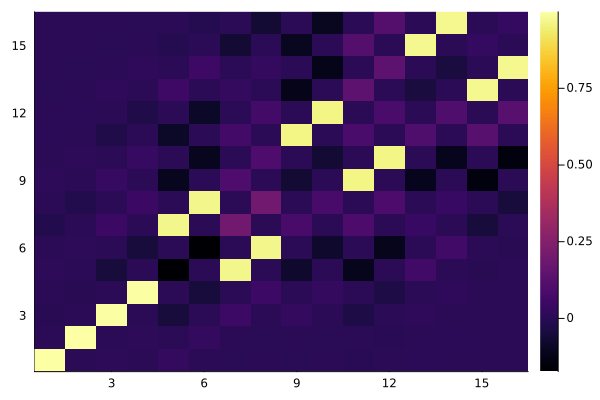

In [57]:
prop = snap_disp_classic_gate([-0.2336736463421616, 0.3669181173739397, 0.23367351861916116, 2.7884901750719577, 3.473215132018274, -2.798740120735896, 0.3535661925951218, 0.2729337101729005, 2.4930916138269876, 2.559441485541238, 0.7091485241335252, -2.7944345471624694, 1.0319374895582125, -2.1004296808769443, -2.116032008122913, 1.1063092045268517, -4.255451376762533, -1.1802232907089818, -2.4715199226985183, 1.883573183371793, -2.5253288264113003, -2.598390890685875, -2.5841992957654143, 4.292139197530038, 3.093112107594174, -3.4869741238804415, 4.589026819714911], X_gate, N * 2, 3,disp,snap)
prop = prop * exp(-im*angle(prop[1, 1]))
heatmap(real(prop))

In [48]:
function half_snap_disp_classic(coefficients, unitary, N, blocks,disp,snap)

    αsi = coefficients[1: blocks]
    βsi = coefficients[blocks + 1: 2*blocks]
    θs = coefficients[2*blocks + 1 : end]
    propagator = Matrix{ComplexF64}(I,N,N)
    q_d = Int(N/4)
    zero = zeros(q_d)

    for i in 1:blocks
        params_snap_1 = [θs[(i - 1) * q_d + 1 : i * q_d]..., zero...]
        params_snap_2 = [zero..., θs[(i - 1) * q_d + 1 : i * q_d]...]
        propagator = propagator * disp(αsi[i]) * snap(params_snap_1) * disp(βsi[i]) * snap(params_snap_2) 
    end

    return 1 - norm(tr(propagator*unitary') / N)^2
    
end

half_snap_disp_classic (generic function with 1 method)

In [49]:
costs = []
for blocks in 6:1:6
    it_costs = []
    for iteration in 1:20
        println("blocks: ", blocks," iterations :", iteration)
        coefficients_initial = zeros((N + 2 ) * blocks)
        coefficients_initial[1: 2*blocks] = rand(2*blocks)*2 .-1
        coefficients_initial[2*blocks + 1:end] = rand(N*blocks) * 2 * pi .- pi
        f(x) = half_snap_disp_classic(x, X_gate, N * 2, blocks,disp,snap)
        res = Optim.optimize(f, coefficients_initial , LBFGS(), Optim.Options(show_trace=true, show_every=100))
        push!(it_costs,Optim.minimum(res))
        println(Optim.minimum(res))
    end
    println(it_costs)
    println(minimum(it_costs))
    push!(costs,minimum(it_costs))
end

blocks: 6 iterations :1
Iter     Function value   Gradient norm 


     0     9.862944e-01     2.145726e-01
 * time: 0.00011992454528808594


   100     6.915621e-02     2.418288e-02
 * time: 7.316092014312744


   200     4.527489e-02     1.330330e-02
 * time: 14.977731943130493


   300     4.356324e-02     3.213524e-03
 * time: 22.591728925704956


   400     4.343611e-02     2.979457e-04
 * time: 30.090646982192993


   500     4.343414e-02     5.994326e-05
 * time: 38.120534896850586


   600     4.343407e-02     9.093978e-06
 * time: 46.301125049591064


   700     4.343407e-02     1.914436e-06
 * time: 54.7076530456543


   800     4.343407e-02     2.281241e-07
 * time: 63.31516408920288


   900     4.343407e-02     6.050307e-08
 * time: 71.98302292823792


0.043434067041440816
blocks: 6 iterations :2
Iter     Function value   Gradient norm 
     0     9.534162e-01     2.149828e-01
 * time: 7.987022399902344e-5


   100     2.243414e-01     2.481416e-02
 * time: 8.425859928131104


   200     1.382369e-01     1.157577e-02
 * time: 16.478510856628418


   300     1.374686e-01     2.230857e-04
 * time: 25.00109601020813


   400     1.374685e-01     9.369827e-06
 * time: 33.658819913864136


   500     1.374685e-01     3.121775e-07
 * time: 42.392796993255615


0.13746845681398046
blocks: 6 iterations :3
Iter     Function value   Gradient norm 
     0     9.935038e-01     7.865659e-02
 * time: 0.00010013580322265625


   100     1.243774e-01     1.565602e-02
 * time: 8.2678701877594


   200     1.225409e-01     4.523832e-03
 * time: 16.749977111816406


   300     1.222416e-01     1.729301e-03
 * time: 26.81965398788452


   400     1.222363e-01     8.771823e-05
 * time: 36.62342715263367


   500     1.222359e-01     1.625724e-05
 * time: 45.18623399734497


   600     1.222359e-01     9.630127e-06
 * time: 54.25364017486572


   700     1.222358e-01     7.898034e-07
 * time: 62.835875034332275


   800     1.222358e-01     3.076765e-07
 * time: 71.19778203964233


   900     1.222358e-01     1.120224e-07
 * time: 79.76186609268188


0.12223584931896425
blocks: 6 iterations :4
Iter     Function value   Gradient norm 
     0     9.952694e-01     4.119478e-02
 * time: 7.605552673339844e-5


   100     9.555912e-02     6.953678e-02
 * time: 8.201290130615234


   200     3.593235e-02     3.724246e-02
 * time: 16.202325105667114


   300     2.568541e-02     1.593509e-03
 * time: 24.73916792869568


   400     2.567553e-02     4.707576e-05
 * time: 33.40610694885254


   500     2.567551e-02     2.748719e-06
 * time: 41.87327194213867


   600     2.567551e-02     2.498502e-07
 * time: 50.46296501159668


0.02567551240697341
blocks: 6 iterations :5
Iter     Function value   Gradient norm 
     0     9.978587e-01     5.307613e-02
 * time: 6.794929504394531e-5


   100     2.112249e-01     3.015769e-02
 * time: 8.068886995315552


   200     1.537367e-01     2.189672e-02
 * time: 16.647818088531494


   300     1.301712e-01     1.707931e-03
 * time: 25.218465089797974


   400     1.301634e-01     9.831658e-06
 * time: 33.84680414199829


   500     1.301634e-01     5.563808e-07
 * time: 42.70217704772949


0.13016338713385045
blocks: 6 iterations :6
Iter     Function value   Gradient norm 
     0     9.540030e-01     1.498998e-01
 * time: 5.316734313964844e-5


   100     2.004964e-01     8.049625e-02
 * time: 8.07091212272644


   200     1.182224e-01     2.745346e-02
 * time: 16.35892605781555


   300     7.690409e-02     1.801888e-02
 * time: 24.77714204788208


   400     5.143629e-02     3.014844e-03
 * time: 33.27541208267212


   500     5.078587e-02     1.885888e-03
 * time: 41.92827320098877


   600     5.031941e-02     9.624492e-03
 * time: 50.78095507621765


   700     5.003238e-02     1.368800e-03
 * time: 59.32821798324585


   800     4.993375e-02     4.112202e-04
 * time: 67.60261416435242


   900     4.993115e-02     1.064066e-04
 * time: 76.29575204849243


  1000     4.993101e-02     3.592154e-05
 * time: 85.26824903488159


0.04993101222584162
blocks: 6 iterations :7
Iter     Function value   Gradient norm 
     0     9.753918e-01     8.453721e-02
 * time: 7.414817810058594e-5


InterruptException: InterruptException: